# Association between Fertility & Local Municipal Characteristics in Denmark 

## Imports

In [307]:
#TODO: check if we use all of them (delete/add)
import geopandas as gpd # for geospatial data handling
import pandas as pd 
import contextily as cx # for plotting
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import matplotlib as mpl # for plotting
from pyproj import CRS # for more advanced CRS modifications and transformations
import numpy as np
import scipy
from scipy import stats # for standardizing the data
from sklearn import linear_model # for multiple regression analysis 
import statsmodels.api as sm # for multiple regression analysis 
import esda # for morans I
from splot.esda import (
    moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
)
from splot.libpysal import plot_spatial_weights # to plot spatial weigths
from pysal.lib import weights  # for weight matrixes
from sklearn import cluster # for clustering
from sklearn.preprocessing import robust_scale # for scaling 
from matplotlib import colors # for coloring the distance based map (fade effect)

# mpl.colors.LinearSegmentedColormap

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

## Load the Data

In [308]:
# Load the data collected from Denmarks Statistics

# total fertility rate (TFR)
data_fer = pd.read_excel('Data/FOD407_Fertility.xlsx')
# education
data_edu = pd.read_excel('Data/HFUDD11_Education.xlsx')
# disposable income
data_inc = pd.read_excel('Data/INDKP101_Income.xlsx')
# dwelings with CPR
data_dwe = pd.read_excel('Data/BOL103_Dwellings.xlsx')
# household wealth
data_wea = pd.read_excel('Data/EJERFOF2_Wealth.xlsx')

## Data processing 

### Fertility 
'TRF' - Total Fertility Rate

In [309]:
# print the initial data
data_fer.head()

,"Fertility rates by age, region and time",Unnamed: 1,Unnamed: 2
0,"Units: Per 1,000 women",NaN,NaN
1,NaN,NaN,2021
2,Total fertility rate,Copenhagen,1563.9
3,NaN,Frederiksberg,1787.8
4,NaN,Dragør,2510.9


In [310]:
data_fer = data_fer.iloc[2:,1:]

In [311]:
# replacing missing values with 0 for convenience (removed later)
data_fer = data_fer.replace('..', 0)
# removing spaces and convert numbers to float
# data_fer['Unnamed: 2'] = data_fer['Unnamed: 2'].str.replace(' ', '').astype(float)
# replacing non-finite values with 0 (missing data - later we drop the municipalities (4 only) with TFR = 0)
data_fer['Unnamed: 2'] = data_fer['Unnamed: 2'].replace([np.inf, -np.inf, np.nan], 0)

In [312]:
# the total fertility rate is per 1000 women, so we change so its easier to understand, also we round the values
data_fer['Unnamed: 2'] = round(data_fer['Unnamed: 2'] / 1000, 2)

In [313]:
# change the name of the columnns
data_fer.rename(columns = {'Unnamed: 1':'municipality_nm', 'Unnamed: 2':'TFR'}, inplace = True)

In [314]:
data_fer

,municipality_nm,TFR
2,Copenhagen,1.56
3,Frederiksberg,1.79
4,Dragør,2.51
5,Tårnby,2.06
6,Albertslund,1.61
...,...,...
96,Morsø,2.08
97,Rebild,2.40
98,Thisted,2.06
99,Vesthimmerlands,1.82


In [315]:
# print the final data 
data_fer.head()

,municipality_nm,TFR
2,Copenhagen,1.56
3,Frederiksberg,1.79
4,Dragør,2.51
5,Tårnby,2.06
6,Albertslund,1.61


### Education 
'master_perc' - the percentage of women in fertile age groups that have master degree or above

In [316]:
# print the initial data
data_edu.head()

,"Educational attainment (15-69 years) by sex, time, age, region and highest education completed",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Units: Number,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Total,H70 Masters programs
2,Women,2021.0,15-19 years,Copenhagen,13267,0
3,NaN,NaN,NaN,Frederiksberg,2306,0
4,NaN,NaN,NaN,Dragør,429,0


In [317]:
data_edu = data_edu.iloc[2:,2:]

In [318]:
# deal with type
columns_to_process = data_edu.columns[2:]
for column in columns_to_process:
    data_edu[column] = data_edu[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [319]:
data_edu.loc[data_edu[['Unnamed: 2']].notnull().any(axis=1)]

,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
2,15-19 years,Copenhagen,13267,0
101,20-24 years,Copenhagen,37149,552
200,25-29 years,Copenhagen,46656,14161
299,30-34 years,Copenhagen,35547,16102
398,35-39 years,Copenhagen,23775,9644
497,40-44 years,Copenhagen,20351,7009
596,45-49 years,Copenhagen,19708,5535


In [320]:
women_15_to_19 = data_edu.iloc[1:100, 1:] 
women_15_to_19.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'total_15_to_19', 'Unnamed: 5':'master_15_to_19'}, inplace = True)

women_20_to_24 = data_edu.iloc[100:199, 1:] 
women_20_to_24.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'total_20_to_24', 'Unnamed: 5':'master_20_to_24'}, inplace = True)

women_25_to_29 = data_edu.iloc[199:298, 1:] 
women_25_to_29.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'total_25_to_29', 'Unnamed: 5':'master_25_to_29'}, inplace = True)

women_30_to_34 = data_edu.iloc[298:397, 1:] 
women_30_to_34.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'total_30_to_34', 'Unnamed: 5':'master_30_to_34'}, inplace = True)

women_35_to_39 = data_edu.iloc[397:496, 1:] 
women_35_to_39.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'total_35_to_39', 'Unnamed: 5':'master_35_to_39'}, inplace = True)

women_40_to_44 = data_edu.iloc[496:595, 1:] 
women_40_to_44.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'total_40_to_44', 'Unnamed: 5':'master_40_to_44'}, inplace = True)

women_45_to_49 = data_edu.iloc[595:, 1:] 
women_45_to_49.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'total_45_to_49', 'Unnamed: 5':'master_45_to_49'}, inplace = True)


In [321]:
data_edu_merged = pd.merge(women_15_to_19, women_20_to_24, on='municipality_nm', how='left')
data_edu_merged = pd.merge(data_edu_merged, women_25_to_29, on='municipality_nm', how='left')
data_edu_merged = pd.merge(data_edu_merged, women_30_to_34, on='municipality_nm', how='left')
data_edu_merged = pd.merge(data_edu_merged, women_35_to_39, on='municipality_nm', how='left')
data_edu_merged = pd.merge(data_edu_merged, women_40_to_44, on='municipality_nm', how='left')
data_edu_merged = pd.merge(data_edu_merged, women_45_to_49, on='municipality_nm', how='left')
data_edu_merged

,municipality_nm,total_15_to_19,master_15_to_19,total_20_to_24,master_20_to_24,total_25_to_29,master_25_to_29,total_30_to_34,master_30_to_34,total_35_to_39,master_35_to_39,total_40_to_44,master_40_to_44,total_45_to_49,master_45_to_49
0,Frederiksberg,2306,0,5164,74,5697,2092,4442,2307,3334,1594,3303,1303,3469.0,1195.0
1,Dragør,429,0,172,1,176,20,309,94,418,134,558,156,530.0,131.0
2,Tårnby,1189,0,865,5,904,94,1248,255,1388,298,1555,280,1649.0,217.0
3,Albertslund,818,0,952,9,867,97,839,119,785,127,879,97,934.0,75.0
4,Ballerup,1471,1,1216,6,1322,160,1529,319,1376,303,1576,288,1703.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,Rebild,946,0,434,2,725,100,971,205,919,174,929,163,1049.0,138.0
95,Thisted,1312,0,827,5,968,77,1107,123,1048,94,1123,82,1282.0,56.0
96,Vesthimmerlands,1060,0,666,6,813,49,957,73,890,60,1041,70,1054.0,49.0
97,Aalborg,5906,1,11902,107,9865,2072,6966,1845,5668,1335,6049,1170,6391.0,837.0


In [322]:
# sum total columns' to 'sum_total' and sum master columns to 'sum_master' and then take the percentage 
# i.e. how many women in perc (age 15-49) have master or above and round it
data_edu_merged['sum_total'] = data_edu_merged.iloc[:,[1,3,5,7,9,11,13]].sum(axis=1)
data_edu_merged['sum_master'] = data_edu_merged.iloc[:,[2,4,6,8,10,11,14]].sum(axis=1)
data_edu_merged['master_perc'] = round(data_edu_merged['sum_master'] * 100 / data_edu_merged['sum_total'], 2)

In [323]:
# drop unnecessary columns
data_edu = data_edu_merged[['municipality_nm', 'master_perc']]

In [324]:
# print the final data
data_edu.head()

,municipality_nm,master_perc
0,Frederiksberg,38.12
1,Dragør,36.19
2,Tårnby,27.55
3,Albertslund,21.50
4,Ballerup,25.71


### Disposable income

'disp_income_avg_k' - average dispodable income for all people (men and women) presented in thousands


In [325]:
# print initial data
data_inc

,"People by type of income, sex, unit, region and time",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Units: -,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,2021.0
2,1 Disposable income (2+30-31-32-35),"Men and women, total",Average income for all people (DKK),Copenhagen,263154.0
3,NaN,NaN,NaN,Frederiksberg,319321.0
4,NaN,NaN,NaN,Dragør,350841.0
...,...,...,...,...,...
95,NaN,NaN,NaN,Morsø,229968.0
96,NaN,NaN,NaN,Rebild,270439.0
97,NaN,NaN,NaN,Thisted,241755.0
98,NaN,NaN,NaN,Vesthimmerlands,244219.0


In [326]:
data_inc = data_inc.iloc[2:,3:]

In [327]:
# rename columns 
data_inc.rename(columns = {'Unnamed: 3':'municipality_nm', 'Unnamed: 4':'disp_income_avg_k'}, inplace = True)

In [328]:
# deal with type
data_inc['disp_income_avg_k'] = data_inc['disp_income_avg_k'].astype(float)

In [329]:
# show in thousands and round the number
data_inc['disp_income_avg_k'] = round(data_inc['disp_income_avg_k']/1000, 2)

In [330]:
# final data 
data_inc.head()

,municipality_nm,disp_income_avg_k
2,Copenhagen,263.15
3,Frederiksberg,319.32
4,Dragør,350.84
5,Tårnby,275.72
6,Albertslund,230.83


### Dwellings

'dwelling_above_74_perc' - percentage of dwellings with more than 74 square meters 


In [331]:
# print initial data
data_dwe

,"Dwellings by type of resident, time, county and size of dwelling in square metre",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Units: Number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,- 50 sq m,50-74 sq m,75-99 sq m,100-124 sq. m,125-149 sq. m,150-174 sq. m,175 sq m and over,Unknown
2,Dwellings with registered population,2021.0,Copenhagen,34050,120748,84785,41034,18102,7823,6859,405
3,NaN,NaN,Frederiksberg,4254,16871,16592,8050,3939,1974,2075,28
4,NaN,NaN,Dragør,172,694,1074,1043,1372,910,832,7
...,...,...,...,...,...,...,...,...,...,...,...
96,NaN,NaN,Morsø,254,1415,1570,1643,1683,1323,2060,4
97,NaN,NaN,Rebild,192,980,1821,2106,2238,2259,3430,26
98,NaN,NaN,Thisted,459,2298,3601,3286,3307,3015,4543,3
99,NaN,NaN,Vesthimmerlands,454,1756,2999,2904,3024,2479,3731,8


Initial data - dwellings with CPR registered persons (occupied dwellings) - count of dwellings per group (groups: 50 kvm, 50-74 kvm, 75-99 kvm, 100-124 kvm, 125-149 kvm, 150-174 kvm, 175 kvm og derover, Uoplyst).


In [332]:
data_dwe = data_dwe.iloc[1:, 2:] # take the data that is actually needed


In [333]:
new_header = data_dwe.iloc[0] # take the first row to use as header

In [334]:
new_header

Unnamed: 2                   NaN
Unnamed: 3             - 50 sq m
Unnamed: 4            50-74 sq m
Unnamed: 5            75-99 sq m
Unnamed: 6         100-124 sq. m
Unnamed: 7         125-149 sq. m
Unnamed: 8         150-174 sq. m
Unnamed: 9     175 sq m and over
Unnamed: 10              Unknown
Name: 1, dtype: object

In [335]:
data_dwe.columns = new_header # get new header

In [336]:
data_dwe = data_dwe.iloc[1:,] # take the data that is actually needed

In [337]:
# deal with type (to float)
columns_to_process = data_dwe.columns[1:]
for column in columns_to_process:
    data_dwe[column] = data_dwe[column].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [338]:
# Calculate the percentage of missing data and sort in the descending order
data_dwe['missing_perc'] =  data_dwe['Unknown'] / (data_dwe.iloc[:,1:].sum(axis=1)) * 100
data_dwe.sort_values('missing_perc', ascending=False)

1,NaN,- 50 sq m,50-74 sq m,75-99 sq m,100-124 sq. m,125-149 sq. m,150-174 sq. m,175 sq m and over,Unknown,missing_perc
61,Fanø,29,201,309,327,318,203,347,13,0.744133
52,Langeland,83,841,1477,1253,1094,746,1116,19,0.286619
26,Helsingør,1824,6079,8098,5069,3896,2268,2328,70,0.236231
43,Odsherred,689,2961,3462,2945,2619,1610,2109,35,0.213025
97,Rebild,192,980,1821,2106,2238,2259,3430,26,0.199203
...,...,...,...,...,...,...,...,...,...,...
15,Ishøj,823,1700,2275,2889,1136,422,409,1,0.010357
78,Silkeborg,1527,5541,9061,7217,6471,5495,7570,4,0.009327
10,Gladsaxe,3507,8384,10822,4620,2130,1373,1194,2,0.006244
94,Læsø,13,134,163,192,181,143,173,0,0.000000


In [339]:
# since the maximum share of  missing values is below 0.8 perc, followed by less than 0.3 perc, we reemove the 
data_dwe.drop(['Unknown', 'missing_perc'], inplace = True, axis = 1)

In [340]:
# sum all 'I alt' and sum all age groups and then take the percentage i.e. how many women in perc (age 15-39) have master or above
data_dwe['Sum_total'] = data_dwe.iloc[:,1:].sum(axis=1)
data_dwe['Sum_more_than_74'] = data_dwe.iloc[:,3:7].sum(axis=1)
data_dwe['dwelling_above_74_perc'] = round(data_dwe['Sum_more_than_74'] * 100 / data_dwe['Sum_total'], 2)

In [341]:
data_dwe

1,NaN,- 50 sq m,50-74 sq m,75-99 sq m,100-124 sq. m,125-149 sq. m,150-174 sq. m,175 sq m and over,Sum_total,Sum_more_than_74,dwelling_above_74_perc
2,Copenhagen,34050,120748,84785,41034,18102,7823,6859,313401,151744,48.42
3,Frederiksberg,4254,16871,16592,8050,3939,1974,2075,53755,30555,56.84
4,Dragør,172,694,1074,1043,1372,910,832,6097,4399,72.15
5,Tårnby,1187,4472,5443,3139,2494,1398,715,18848,12474,66.18
6,Albertslund,1899,1639,3599,3027,1322,648,236,12370,8596,69.49
...,...,...,...,...,...,...,...,...,...,...,...
96,Morsø,254,1415,1570,1643,1683,1323,2060,9948,6219,62.52
97,Rebild,192,980,1821,2106,2238,2259,3430,13026,8424,64.67
98,Thisted,459,2298,3601,3286,3307,3015,4543,20509,13209,64.41
99,Vesthimmerlands,454,1756,2999,2904,3024,2479,3731,17347,11406,65.75


In [342]:
# rename columns 
data_dwe.columns = data_dwe.columns.where(~data_dwe.columns.isna(), 'municipality_nm')

In [343]:
# drop unnecessary columns
data_dwe = data_dwe[['municipality_nm', 'dwelling_above_74_perc']]

In [344]:
#  final data
data_dwe

1,municipality_nm,dwelling_above_74_perc
2,Copenhagen,48.42
3,Frederiksberg,56.84
4,Dragør,72.15
5,Tårnby,66.18
6,Albertslund,69.49
...,...,...
96,Morsø,62.52
97,Rebild,64.67
98,Thisted,64.41
99,Vesthimmerlands,65.75


### Wealth

'household_wealth_avg_k' - average wealth (DKK) of the household for the the real estate, owners

In [345]:
data_wea = pd.read_excel('Data/EJERFOF2_Wealth.xlsx')

In [346]:
data_wea = data_wea.iloc[3:,2:]

In [347]:
# deal with type
data_wea['Unnamed: 3'] = data_wea['Unnamed: 3'].apply(lambda x: float(x.replace(' ', '')) if isinstance(x, str) else x)

In [348]:
# rename columns
data_wea.rename(columns = {'Unnamed: 2':'municipality_nm', 'Unnamed: 3':'household_wealth_avg_k'}, inplace = True)

In [349]:
# show in thousands and round the number
data_wea['household_wealth_avg_k'] = round(data_wea['household_wealth_avg_k']/1000, 2)

In [350]:
data_wea.head()

,municipality_nm,household_wealth_avg_k
3,Copenhagen,3629.88
4,Frederiksberg,4487.73
5,Dragør,5105.65
6,Tårnby,3408.59
7,Albertslund,3088.08


### Final dataset

In [351]:
# load geometries for Danish municipaliities
geometries = gpd.read_file('Data/municipalities_dk.gpkg')

In [352]:
# check if the data have the same number of municipalities (there should be 98)
print(geometries.shape)
print(data_fer.shape)
print(data_edu.shape)
print(data_dwe.shape)
print(data_fer.shape)
print(data_wea.shape)

(99, 5)
(99, 2)
(99, 2)
(99, 2)
(99, 2)
(98, 2)


In [353]:
# Merge the data frames based on the 'municipality_nm' column using left join
merged_df = pd.merge(data_fer, data_edu, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_inc, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_dwe, on='municipality_nm', how='left')
merged_df = pd.merge(merged_df, data_wea, on='municipality_nm', how='left')

In [354]:
# change name to the same language
merged_df['municipality_nm'] = merged_df['municipality_nm'].replace('Copenhagen', 'København')

In [355]:
# Find rows with null values
null_rows = merged_df[merged_df.isnull().any(axis=1)]

print(null_rows)

   municipality_nm  TFR  master_perc  disp_income_avg_k  \
29     Christiansø  0.0        38.46                NaN   

    dwelling_above_74_perc  household_wealth_avg_k  
29                     NaN                     NaN  


In [356]:
# Drop Christiansø as it is not a municipality 
merged_df = merged_df.drop(merged_df[merged_df['municipality_nm'] == 'Christiansø'].index)

In [357]:
# print info about the the data set
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 98
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   municipality_nm         98 non-null     object 
 1   TFR                     98 non-null     float64
 2   master_perc             98 non-null     float64
 3   disp_income_avg_k       98 non-null     float64
 4   dwelling_above_74_perc  98 non-null     float64
 5   household_wealth_avg_k  98 non-null     float64
dtypes: float64(5), object(1)
memory usage: 5.4+ KB


In [358]:
# rename columns
geometries = geometries.rename(columns={'navn': 'municipality_nm'}) #added

In [359]:
# merge dataset with geometries
data = merged_df.merge(geometries, on='municipality_nm')

In [360]:
# check if dataset have 98 mucinipalities
data.shape

(98, 10)

In [361]:
data.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,kommunekode,region,municipal_id,geometry
0,København,1.56,36.67,263.15,48.42,3629.88,0101,NaN,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
1,Frederiksberg,1.79,38.12,319.32,56.84,4487.73,0147,NaN,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
2,Dragør,2.51,36.19,350.84,72.15,5105.65,0155,NaN,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
3,Tårnby,2.06,27.55,275.72,66.18,3408.59,0185,NaN,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
4,Albertslund,1.61,21.50,230.83,69.49,3088.08,0165,NaN,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


In [362]:
# municipalities where TFR = 0 has actually missing data, so lets see which ones they are
data[data['TFR'] == 0]

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,kommunekode,region,municipal_id,geometry
55,Ærø,0.0,21.93,224.59,62.82,1733.19,0492,NaN,492,"MULTIPOLYGON (((577300.890 6092306.180, 577293..."
58,Fanø,0.0,26.58,273.56,66.72,2575.21,0563,NaN,563,"MULTIPOLYGON (((467916.440 6135175.900, 467908..."
74,Samsø,0.0,28.95,244.54,61.76,2551.29,0741,NaN,741,"MULTIPOLYGON (((603519.380 6196685.170, 603520..."
91,Læsø,0.0,18.10,234.39,67.97,1740.73,0825,NaN,825,"MULTIPOLYGON (((615696.720 6346079.540, 615701..."


In [363]:
# drop those whith TFR = 0, since there is no data about fertility in the 4 small islands and they become outliers. 
data = data[data['TFR'] != 0]

In [364]:
# drop other unnecessary data
data.drop(['region', 'kommunekode'], axis=1, inplace=True)

In [365]:
# check shape again
data.shape

(94, 8)

In [366]:
# save the DataFrame to a xlsx file
data.to_excel('data.xlsx', index=False)

In [367]:
# create a final Geo dataset (add geometry)
gdf = gpd.GeoDataFrame(data, geometry=data.geometry, crs = 'EPSG:25832') #added

In [368]:
# Print final geo dataset
gdf.head()

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry
0,København,1.56,36.67,263.15,48.42,3629.88,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090..."
1,Frederiksberg,1.79,38.12,319.32,56.84,4487.73,147,"MULTIPOLYGON (((722290.770 6177984.800, 722299..."
2,Dragør,2.51,36.19,350.84,72.15,5105.65,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555..."
3,Tårnby,2.06,27.55,275.72,66.18,3408.59,185,"MULTIPOLYGON (((729600.300 6172549.660, 729596..."
4,Albertslund,1.61,21.50,230.83,69.49,3088.08,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352..."


In [369]:
gdf = gdf.set_index("municipal_id", drop=False) # we use the id columns as index for easy access to our spatial weights 

In [370]:
gdf.index

Int64Index([101, 147, 155, 185, 165, 151, 153, 157, 159, 161, 163, 167, 169,
            183, 173, 175, 187, 201, 240, 210, 250, 190, 270, 260, 217, 219,
            223, 230, 400, 253, 259, 350, 265, 269, 320, 376, 316, 326, 360,
            370, 306, 329, 330, 340, 336, 390, 420, 430, 440, 482, 410, 480,
            450, 461, 479, 530, 561, 607, 510, 621, 540, 550, 573, 575, 630,
            580, 710, 766, 615, 707, 727, 730, 740, 746, 706, 751, 657, 661,
            756, 665, 760, 779, 671, 791, 810, 813, 860, 849, 846, 773, 840,
            787, 820, 851],
           dtype='int64', name='municipal_id')

In [371]:
# # save the GeoDataFrame to a GeoJSON file
# gdf.to_file('Data/gdf.geojson', driver='GeoJSON')

## EDA

In [372]:
# descriptive statistics
data.describe()

,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,1.928085,23.625957,268.902447,66.099255,2991.963511,453.957447
std,0.223160,5.255983,49.549007,4.709047,1066.650133,236.488283
min,1.550000,16.730000,216.230000,48.420000,1901.420000,101.000000
25%,1.772500,19.662500,242.442500,64.435000,2264.360000,232.500000
50%,1.880000,21.900000,257.540000,66.010000,2669.415000,415.000000
75%,2.060000,25.562500,273.312500,68.815000,3476.357500,669.500000
max,2.510000,38.890000,529.710000,79.550000,7895.550000,860.000000


In [373]:
characteristics = ['TFR','master_perc', 'disp_income_avg_k','dwelling_above_74_perc', 'household_wealth_avg_k']
characteristics_nm = ['TFR (Total Fertility Rate)', 'Master degree above (%)', 'Disposable income (thousands, dkk)', 'Dwelling above 74 sq. m. (%)', 'Household wealth (thousands, dkk)']

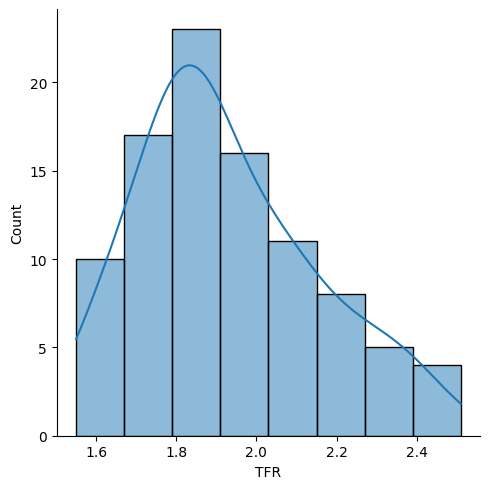

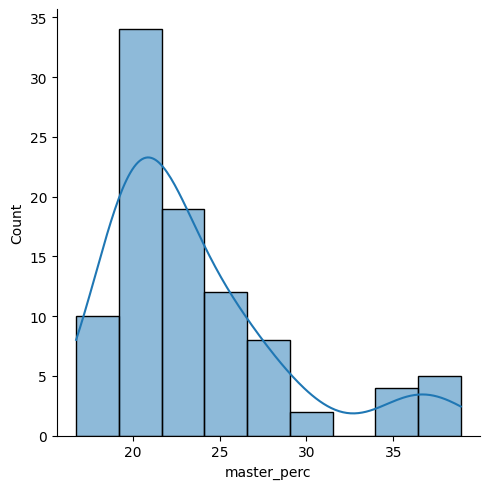

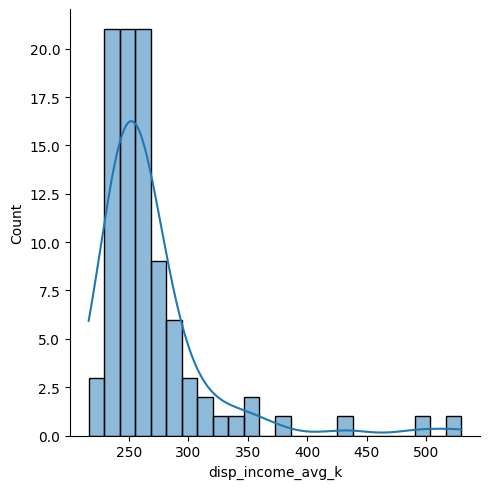

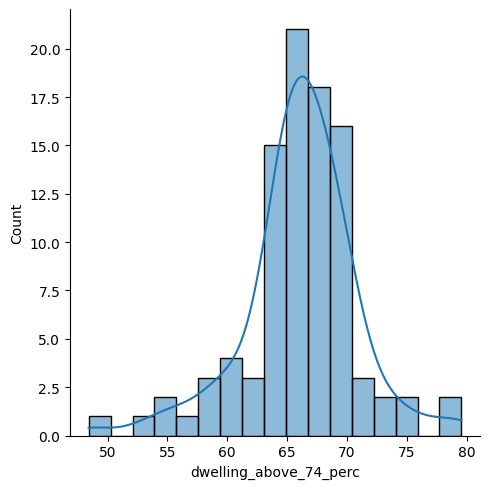

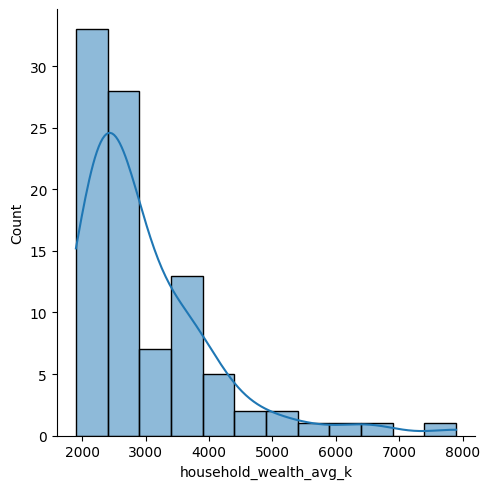

In [374]:
# Distributions of characteristics ()
for feature in characteristics:
    sns.displot(data, x = feature, kde = True)

## Multiple regression analysis

### Relationship

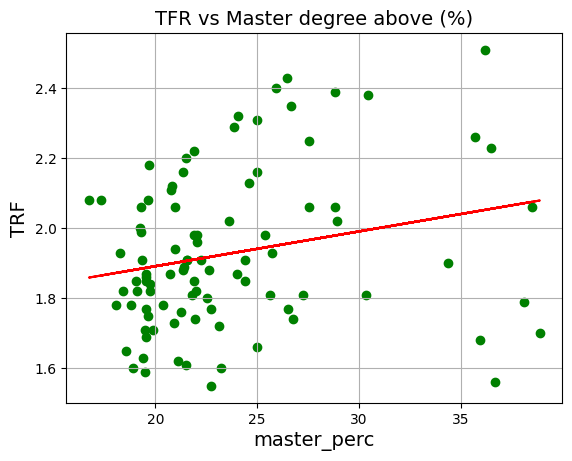

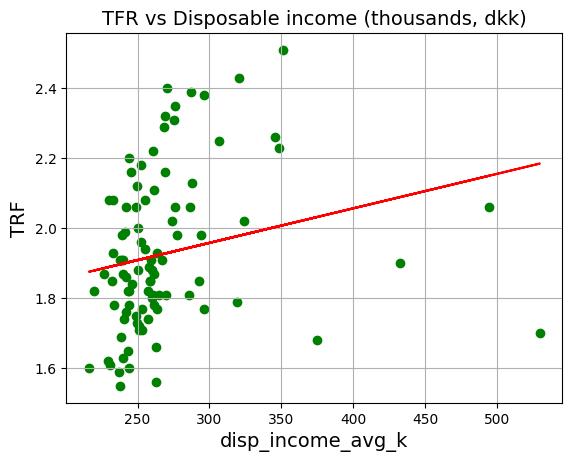

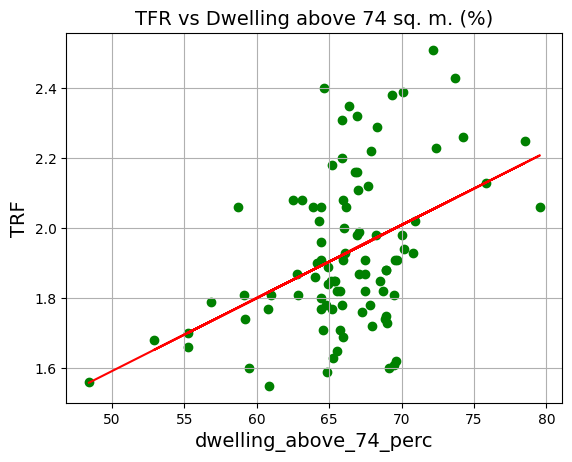

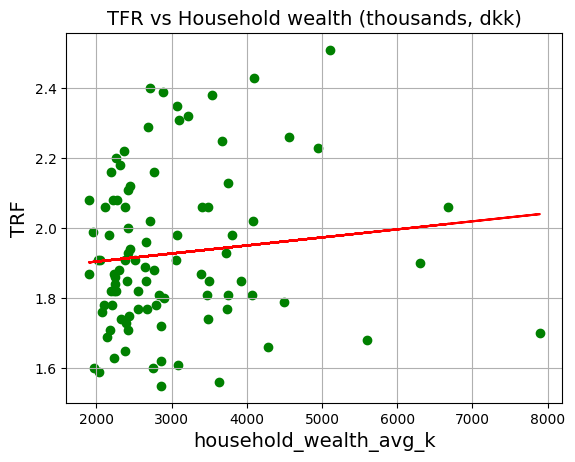

In [375]:
# plot relationship between fertility rate and other characteristics 
for i, variable in enumerate(characteristics[1:]): # 1: -> because we dont include TFR
    # linear regression 
    coefficients = np.polyfit(data[variable], data['TFR'], 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    data['r_line'] = data[variable] * slope + intercept
    # plot
    plt.scatter(data[variable], data['TFR'], color='green')
    plt.plot(data[variable], data['r_line'], color='red')
    plt.title(f'TFR vs {characteristics_nm[i+1]}', fontsize=14) # i+1 -> because we dont include TFR
    plt.xlabel(variable, fontsize=14)
    plt.ylabel('TRF', fontsize=14)
    plt.grid(True)
    plt.show()

### Correlation

In [376]:
data.columns

Index(['municipality_nm', 'TFR', 'master_perc', 'disp_income_avg_k',
       'dwelling_above_74_perc', 'household_wealth_avg_k', 'municipal_id',
       'geometry', 'r_line'],
      dtype='object')

In [377]:
# check if variables are correlated
data[['TFR', 'master_perc', 'disp_income_avg_k',
       'dwelling_above_74_perc', 'household_wealth_avg_k']].corr()


,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k
TFR,1.000000,0.234026,0.218995,0.440265,0.109989
master_perc,0.234026,1.000000,0.819356,-0.213579,0.881641
disp_income_avg_k,0.218995,0.819356,1.000000,-0.165318,0.925041
dwelling_above_74_perc,0.440265,-0.213579,-0.165318,1.000000,-0.223584
household_wealth_avg_k,0.109989,0.881641,0.925041,-0.223584,1.000000


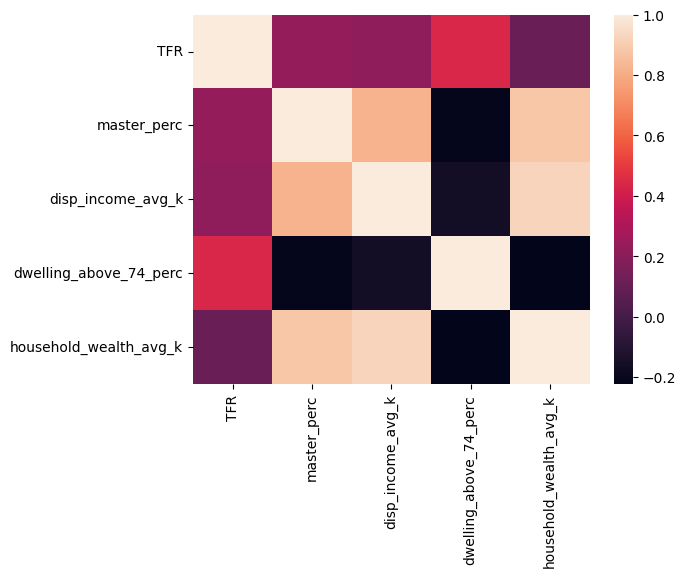

In [378]:
# plot heatmap
sns.heatmap(data[['TFR', 'master_perc', 'disp_income_avg_k', 'dwelling_above_74_perc', 'household_wealth_avg_k']].corr());

### Multiple linear regression analysis

Source for the part of the code:  https://datatofish.com/multiple-linear-regression-python/

In [379]:
characteristics

['TFR',
 'master_perc',
 'disp_income_avg_k',
 'dwelling_above_74_perc',
 'household_wealth_avg_k']

In [380]:
# Z-Score using scipy
data['TFR_st'] = stats.zscore(data['TFR'])
data['master_perc_st'] = stats.zscore(data['master_perc'])
data['disp_income_avg_k_st'] = stats.zscore(data['disp_income_avg_k'])
data['dwelling_above_74_perc_st'] = stats.zscore(data['dwelling_above_74_perc'])
data['household_wealth_avg_k_st'] = stats.zscore(data['household_wealth_avg_k'])

In [381]:
x = data[['master_perc_st', 'disp_income_avg_k_st', 'dwelling_above_74_perc_st', 'household_wealth_avg_k_st']]
y = data['TFR_st'] 

# with sklearn
regr = linear_model.LinearRegression()
regr.fit(x, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 -2.299994347344529e-15
Coefficients: 
 [ 0.63898231  0.66008294  0.47154872 -0.95853755]


In [382]:
# with statsmodels
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 TFR_st   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     14.60
Date:                Thu, 25 May 2023   Prob (F-statistic):           3.29e-09
Time:                        11:29:47   Log-Likelihood:                -109.66
No. Observations:                  94   AIC:                             229.3
Df Residuals:                      89   BIC:                             242.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## ESDA

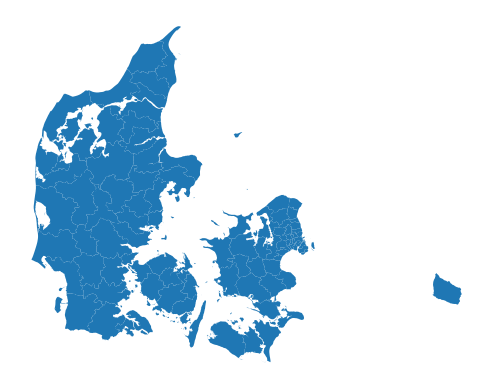

In [383]:
# plot the geospatial data as a map on a plot
ax = gdf.plot(linewidth=0.3);
ax.set_axis_off()

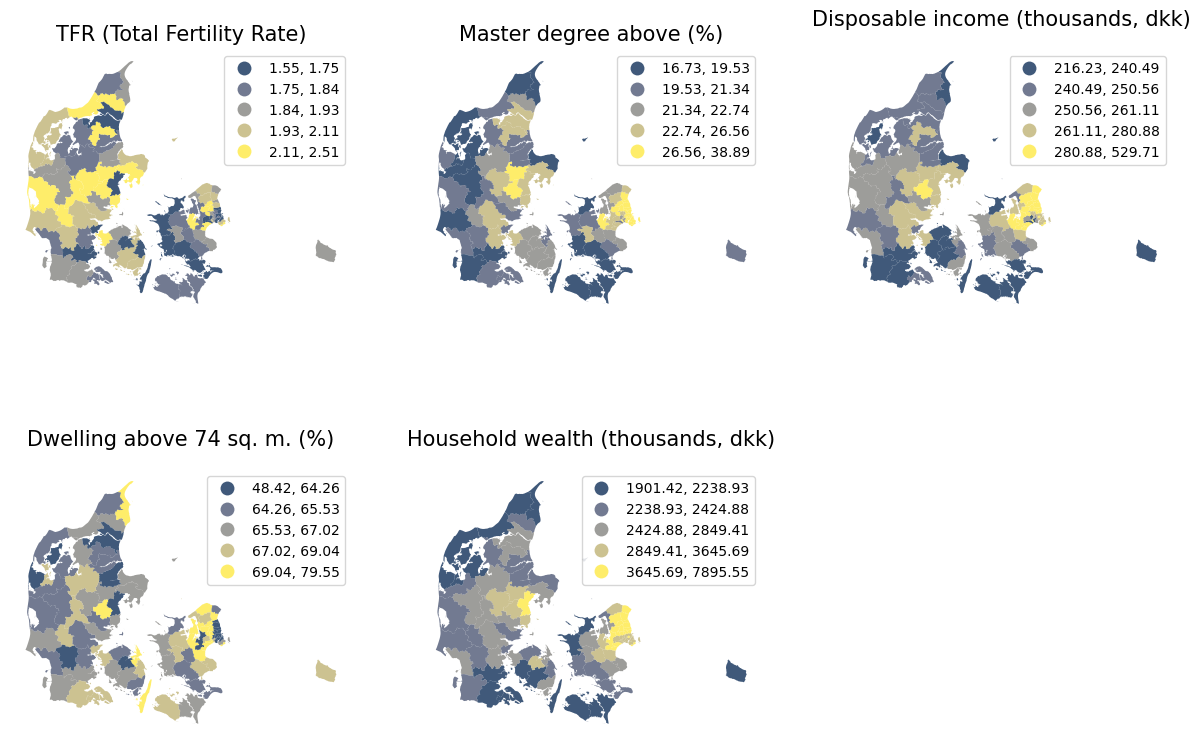

In [384]:
# plot characteristics on the map with their values
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()

for i, col in enumerate(characteristics):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    # TODO: Anna: do you know why we use these specific parameters? add comments please 
    gdf.plot(
        column=col, 
        ax=ax, 
        scheme='Quantiles', 
        linewidth=0.2, 
        cmap='cividis',
        alpha=0.75,
        legend=True,  # Add legend
        legend_kwds={'fontsize':10}
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title 
    ax.set_title(characteristics_nm[i], fontsize = 15)
    
#plt.savefig('data_vis.png')

plt.show()

## Spatial Weigths

### KNN

In [385]:
# Calculate knn weight matrix
w_knn = weights.KNN.from_dataframe(gdf, k=8)

c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


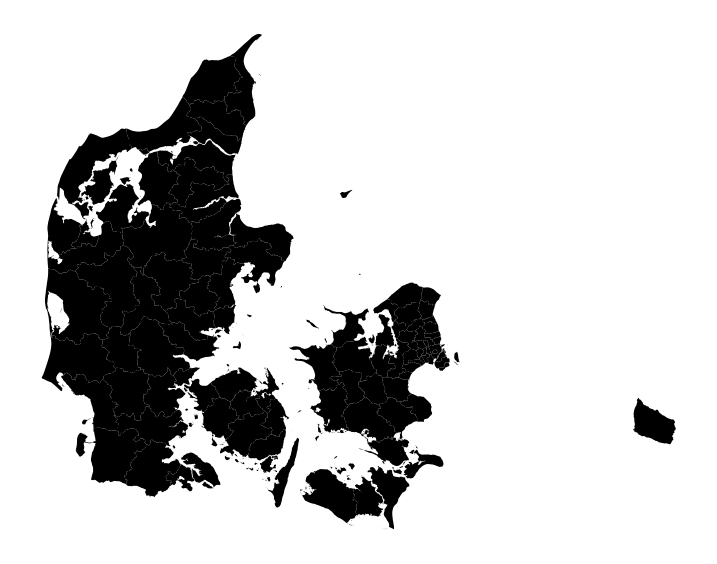

In [386]:
# knn plot to see if there are any islands
ax = gdf.plot(color='k', linewidth=0.2, figsize=(9, 9))
gdf.loc[w_knn.islands, :].plot(color='red', linewidth=0.2, ax=ax)
ax.set_axis_off()

c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\geopandas\plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


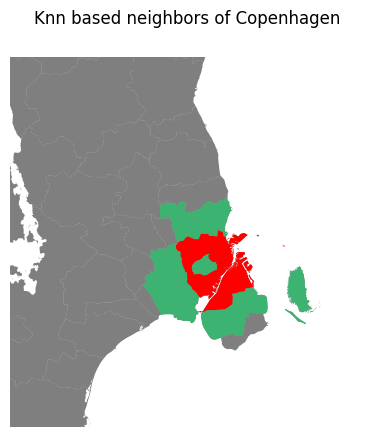

In [387]:
# Plot the neighbots of Copenhagen as an example

mun_id = 101 

# Setup figure
f, ax = plt.subplots(1)
# Plot base layer of polygons
gdf.plot(ax=ax, facecolor='k', linewidth=1, alpha=0.5)
# Select focal polygon
focus = gdf.loc[[mun_id], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=1, ax=ax)
# Plot neighbors
neis = gdf.loc[list(w_knn[mun_id].keys()), :]
neis_w = list(w_knn[mun_id].values())
neis['neis_w'] = neis_w
neis.plot(column='neis_w', ax=ax, linewidth=0.5, color='mediumseagreen')
# Title
f.suptitle("Knn based neighbors of Copenhagen")
# Style and display on screen
ax.set_xlim(690000, 750000)
ax.set_ylim(6150000, 6210000)
ax.set_axis_off()
plt.show()


### Distance band

In [388]:
# Calculate distance based (continous values) weight matrix with different thresholds for as circle radius
w_dist40kmC = weights.DistanceBand.from_dataframe(gdf, 40000, binary=False)
w_dist50kmC = weights.DistanceBand.from_dataframe(gdf, 50000, binary=False)
w_dist60kmC = weights.DistanceBand.from_dataframe(gdf, 60000, binary=False)

c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\scipy\sparse\_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)
c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 400.
  warnings.warn(message)


In [389]:
# the average number of neighbors per municipality
print('40km:', w_dist40kmC.mean_neighbors)
print('50km:', w_dist50kmC.mean_neighbors)
print('60km:', w_dist60kmC.mean_neighbors)

40km: 13.319148936170214
50km: 17.25531914893617
60km: 20.617021276595743


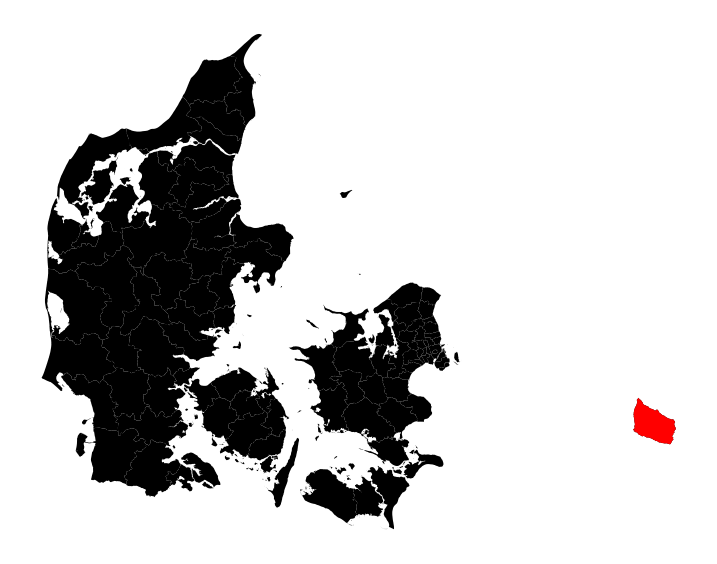

In [390]:
# distance based plot to see if there are any islands
# Note: the plot is the same for 40km, 50km, 60km, so for convenience we left only one
ax = gdf.plot(color='k', linewidth=0.2, figsize=(9, 9))
gdf.loc[w_dist60kmC.islands, :].plot(color='red', linewidth=0.2, ax=ax)
ax.set_axis_off()

In [391]:
# Since Bronholm in an island and we are not connecting it even with 60km radius, we will drop it:
gdf = gdf.drop(w_dist60kmC.islands)

In [392]:
# Since we cant decide based on visual inspection(40/50/60), we calculate Minimun threshold to help us decide.

# Extract centroids
cents = gdf.centroid
# Extract coordinates into an array
pts = pd.DataFrame(
    {"X": cents.x, "Y": cents.y}
).values

min_thr = weights.min_threshold_distance(pts)
print('Minimum threshold:', min_thr)


Minimum threshold: 33902.55967045878


In [393]:
# according to the the minimum threshold, we need to use at least ~33903m to have fully connected map

# after dropping an Island we need to recalculate the weigths
w = weights.DistanceBand.from_dataframe(gdf, 50000, binary=False)

c:\Users\sutov\anaconda3\envs\gds_py\lib\site-packages\scipy\sparse\_data.py:117: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [394]:
# Then we standardize weights, so each row sums up to 1
w.transform = 'R'

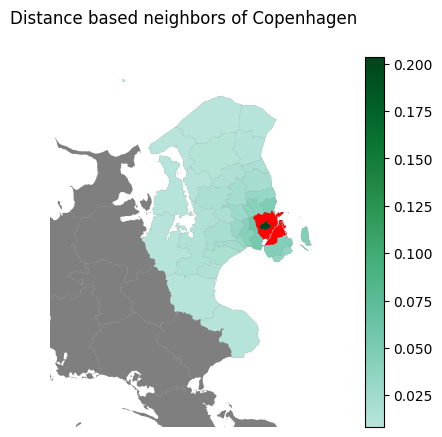

In [395]:
mun_id = 101 # the id of municipality which we want to show as an example

orig_cmap = plt.cm.BuGn
colors = orig_cmap(np.linspace(0.3, 1.0, 10))
cmap_cust = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)

# Setup figure
f, ax = plt.subplots(1)
# Plot base layer of polygons
gdf.plot(ax=ax, facecolor='k', linewidth=1, alpha=0.5)
# Select focal polygon
focus = gdf.loc[[mun_id], ['geometry']]
# Plot focal polygon
focus.plot(facecolor='red', alpha=1, linewidth=1, ax=ax)
# Plot neighbors
neis = gdf.loc[list(w[mun_id].keys()), :]
neis_w = list(w[mun_id].values())
neis['neis_w'] = neis_w
neis.plot(column='neis_w', ax=ax, linewidth=0.5, cmap=cmap_cust, legend=True)
# Title
f.suptitle("Distance based neighbors of Copenhagen")
# Style and display on screen
ax.set_xlim(640000, 750000)
ax.set_ylim(6100000, 6240000)
ax.set_axis_off()
plt.show()


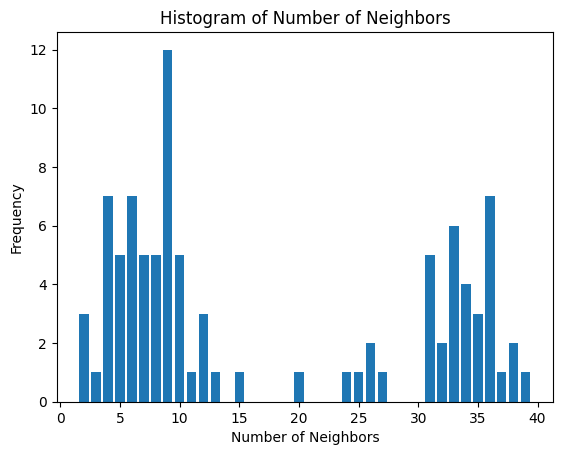

In [396]:
# Get the number of neighbors for each municipality
neighbor_counts = w.neighbors
# Count the occurrences of each number of neighbors
counts = {}
for neighbors in neighbor_counts.values():
    count = len(neighbors)
    counts[count] = counts.get(count, 0) + 1

# Extract the counts and corresponding number of neighbors
num_neighbors = list(counts.keys())
frequency = list(counts.values())

# Create a histogram
plt.bar(num_neighbors, frequency)

# Customize the plot as desired (e.g., add a title, x-label, y-label, etc.)
plt.title('Histogram of Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Frequency')

# Show the plot
plt.show()

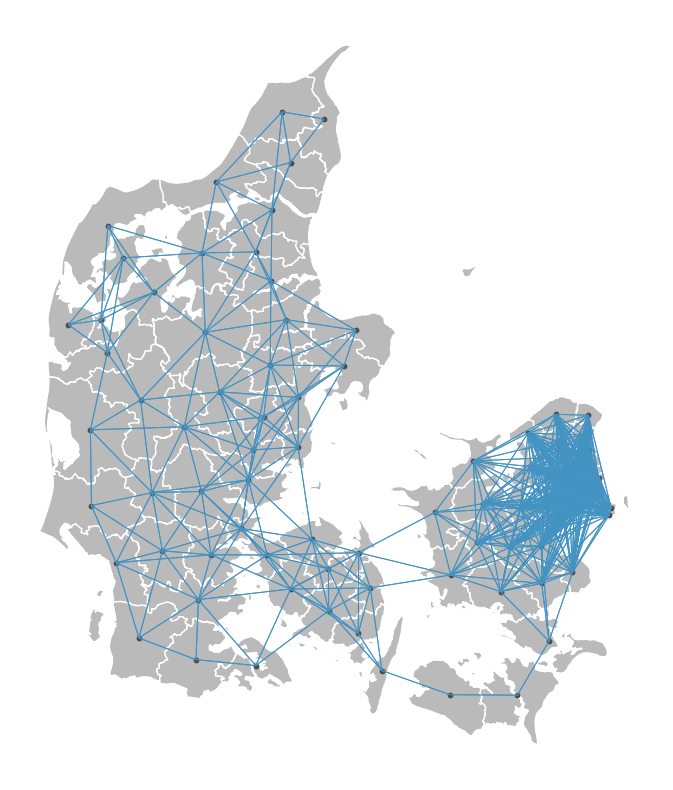

In [397]:
# from the plot above we can see that while some of the municipalities have a lot of neighbours, others have very little
# lets inspect that visually:
plot_spatial_weights(w, gdf, indexed_on="municipal_id");

In [398]:
# we can see that bigger municipalities are the ones taht have less neighbours as expected, which makes sense

## Spatial Lag

In [399]:
# EXAMPLE for one variable only

# calculate spatial lag for TFR
gdf['w_TFR'] = weights.lag_spatial(w, gdf['TFR']) # we pass the weights object and the column with values to base the spatial lag on
gdf[['municipality_nm', 'TFR', 'w_TFR']].head()

,municipality_nm,TFR,w_TFR
municipal_id,,,
101,København,1.56,1.890705
147,Frederiksberg,1.79,1.840712
155,Dragør,2.51,1.897847
185,Tårnby,2.06,1.960156
165,Albertslund,1.61,1.902290


Interpretation:
Copenhagen, where total fertility rate is 1.56%, is surrounded by neighbouring municipalies which, on average, have total fertility rate of
1.9%.

In [400]:
# For all characteristics 

for variable in characteristics:
    # calculate spatial lag for TFR
    gdf[f'w_{variable}'] = weights.lag_spatial(w, gdf[variable]) # we pass the weights object and the column with values to base the spatial lag on
    # standardize the variable
    gdf[f'{variable}_std'] = (
        gdf[variable] - gdf[variable].mean()
    ) / gdf[variable].std()
    # spatial lag
    gdf[f'w_{variable}_std'] = weights.lag_spatial(w, gdf[f'{variable}_std'])

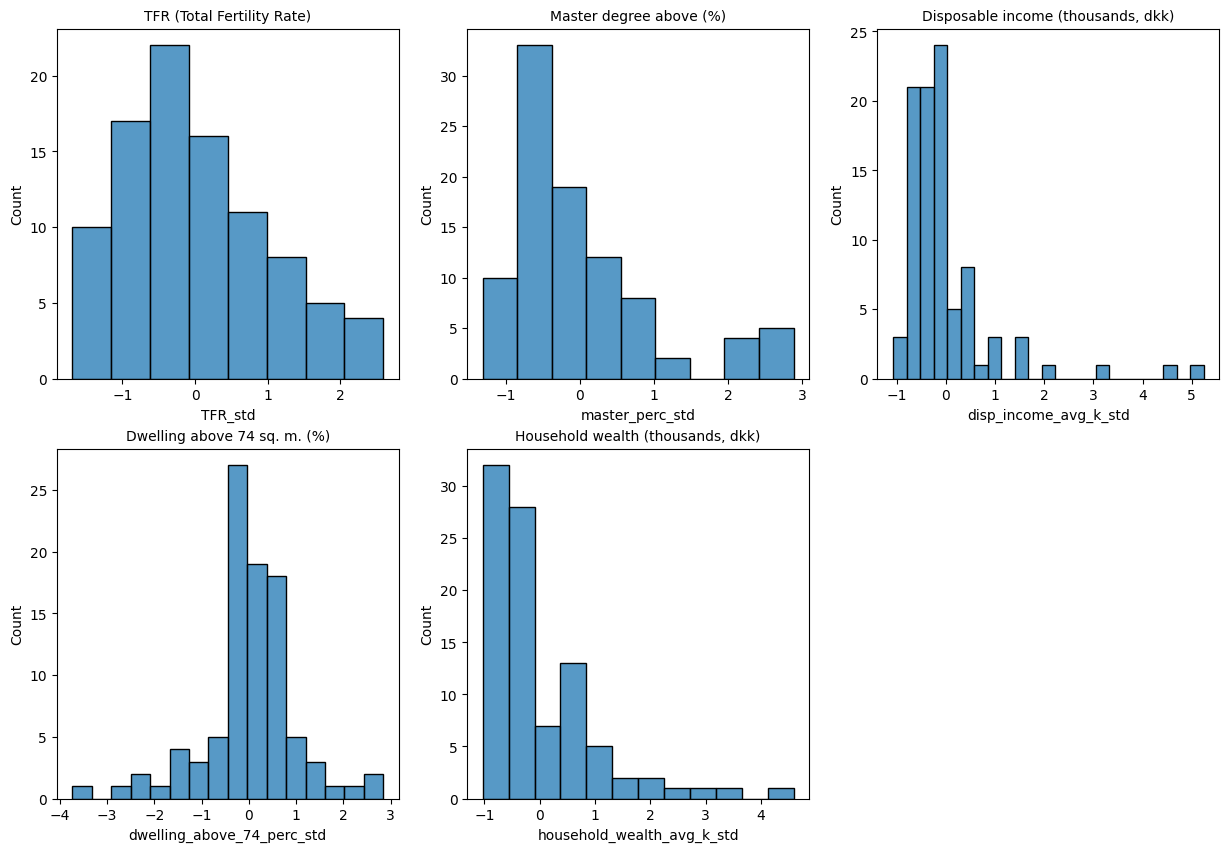

In [401]:
# Plot spatial lags
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()


for i, variable in enumerate(characteristics):
    # select the axis where the map will go
    ax = axs[i]
    # plot
    sns.histplot(gdf[f'{variable}_std'], ax=ax);

    # # Remove axis clutter
    # ax.set_axis_off()
    # Set the axis title 
    ax.set_title(characteristics_nm[i], fontsize = 10)

plt.show()

insights you can derive from interpreting a histogram of spatial lags:

    Spatial Autocorrelation: By examining the shape and distribution of the histogram, you can assess the presence and strength of spatial autocorrelation. Spatial autocorrelation refers to the tendency of similar values to occur near each other in space. If the histogram exhibits a peak or a distinct pattern, it suggests the presence of spatial autocorrelation. A symmetric distribution may indicate a random spatial pattern, while a skewed distribution could suggest a spatial clustering or gradient.

    Spatial Clusters: If the histogram shows clusters or peaks at specific lag distances, it indicates the presence of spatial clusters or regions with similar values. This suggests that neighboring observations are more similar to each other than to observations at larger distances. It can indicate the presence of spatial hotspots or coldspots, highlighting areas with similar characteristics.

    Spatial Dispersion: Alternatively, a histogram that shows a relatively flat distribution across various lag distances suggests a spatially dispersed pattern. This means that there is no significant spatial autocorrelation, and neighboring observations do not exhibit similar values. It implies a lack of clustering or a random spatial distribution.

    Scale of Spatial Dependence: The histogram of spatial lags can provide insights into the scale of spatial dependence. The presence of peaks or clusters at specific lag distances indicates the range at which spatial autocorrelation occurs. A sharp peak suggests a strong spatial dependence at a specific distance, while a broader distribution indicates autocorrelation over a wider range of distances.

    Outliers: Examining the tails of the histogram can reveal outliers or extreme values in the spatial lags. Outliers in spatial lags may indicate areas or observations with unique characteristics or spatial relationships. These outliers might be worth investigating further to understand the underlying factors driving their presence.

## Global spatial autocorrelation (Moran's I)
Assesses the similarity or dissimilarity of attribute values between neighboring locations. 

In [402]:
# Calculate Moran's I for each variable
mi_results_save = [esda.Moran(gdf[variable], w) for variable in characteristics]
# Structure results as a list of tuples
mi_results = [(variable, res.I, res.p_sim) for variable,res in zip(characteristics, mi_results_save)]
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Variable', "Moran's I", 'P-value']
).set_index('Variable')
table

,Moran's I,P-value
Variable,,
TFR,0.059952,0.070
master_perc,0.511458,0.001
disp_income_avg_k,0.333148,0.001
dwelling_above_74_perc,0.083671,0.031
household_wealth_avg_k,0.533961,0.001


Global Morans I  for TFR (Total Fertility Rate)


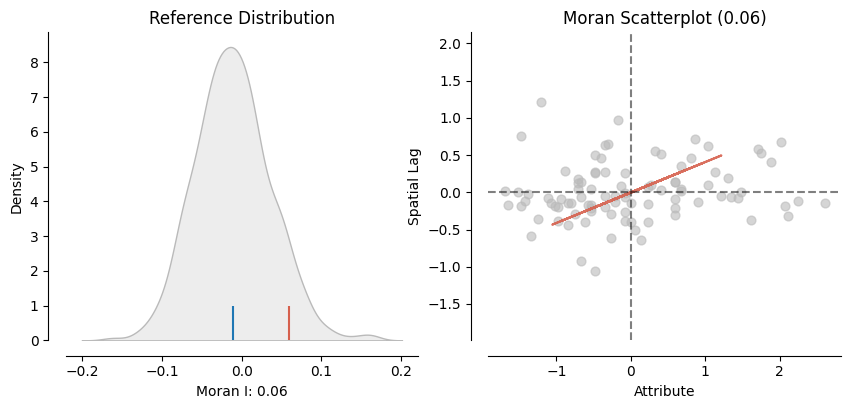

Global Morans I  for Master degree above (%)


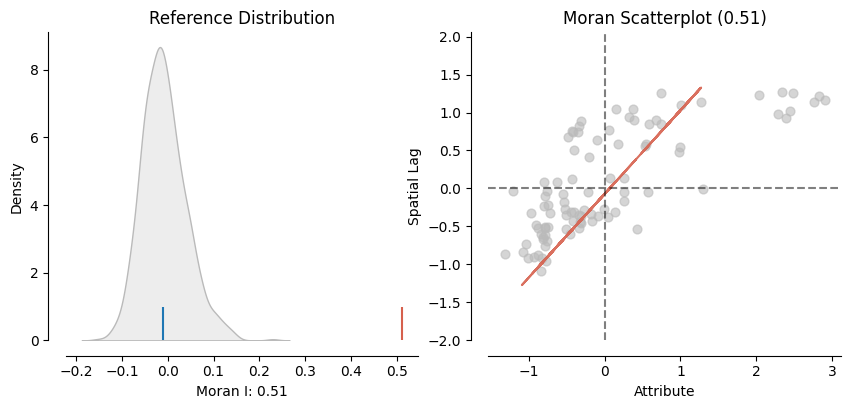

Global Morans I  for Disposable income (thousands, dkk)


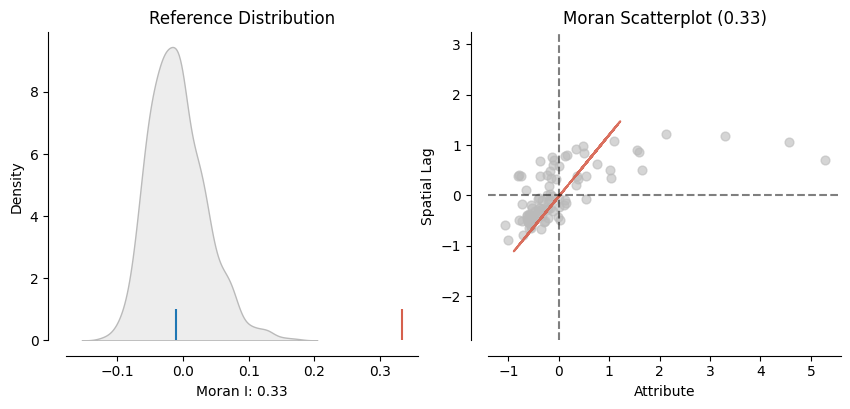

Global Morans I  for Dwelling above 74 sq. m. (%)


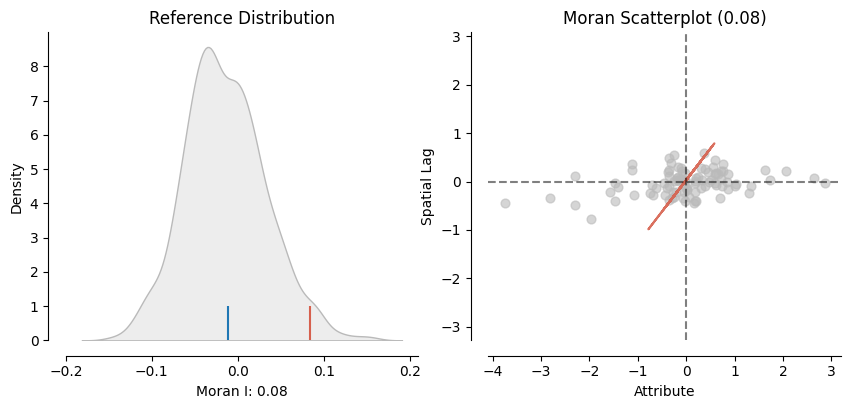

Global Morans I  for Household wealth (thousands, dkk)


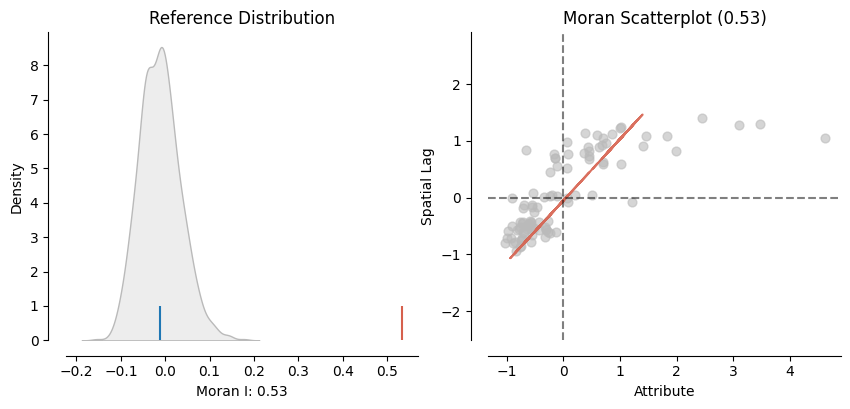

In [403]:
# Potting the reference distribution (the null distribution of Moran's I statistic) amd Moran's I scatter plot 
# (quantifies the degree of similarity or dissimilarity between the attribute values of neighboring spatial units).
for i, variable in enumerate(characteristics):
    print(f'Global Morans I  for {characteristics_nm[i]:}')
    plot_moran(mi_results_save[i])
    plt.show()

In the context of spatial autocorrelation analysis, the reference distribution in the plot_moran function typically refers to the null distribution of Moran's I statistic. Moran's I is a measure of spatial autocorrelation that quantifies the degree of similarity or dissimilarity between the attribute values of neighboring spatial units.

The reference distribution is obtained through Monte Carlo simulation, where random permutations of the attribute values are generated under the assumption of spatial randomness. The Moran's I statistic is calculated for each permutation, resulting in a distribution of Moran's I values. This distribution represents the expected values of Moran's I under the null hypothesis of no spatial autocorrelation.

In the plot_moran function, the reference distribution is plotted along with the observed Moran's I statistic as a histogram. The observed Moran's I value is usually shown as a vertical line on the plot. By comparing the observed Moran's I value to the reference distribution, you can assess whether there is a significant departure from spatial randomness.

If the observed Moran's I value falls within the central portion of the reference distribution (i.e., the histogram), it suggests that the spatial pattern in the data is consistent with spatial randomness. On the other hand, if the observed Moran's I value falls in the tails of the reference distribution, it indicates significant spatial autocorrelation. Positive spatial autocorrelation suggests clustering of similar attribute values, while negative spatial autocorrelation suggests dispersion or segregation of dissimilar attribute values.

In summary, the reference distribution in the plot_moran function serves as a reference point for evaluating the observed spatial autocorrelation and determining whether it is statistically significant.

In [404]:
# Highest fertility top 10
gdf.sort_values(by = 'TFR', ascending=False)[:10]

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry,w_TFR,TFR_std,...,w_master_perc_std,w_disp_income_avg_k,disp_income_avg_k_std,w_disp_income_avg_k_std,w_dwelling_above_74_perc,dwelling_above_74_perc_std,w_dwelling_above_74_perc_std,w_household_wealth_avg_k,household_wealth_avg_k_std,w_household_wealth_avg_k_std
municipal_id,,,,,,,,,,,,,,,,,,,,,
155,Dragør,2.51,36.19,350.84,72.15,5105.65,155,"MULTIPOLYGON (((729575.650 6168529.720, 729555...",1.897847,2.591721,...,0.919264,293.924436,1.642144,0.495099,64.924023,1.281727,-0.245202,3878.203235,1.971224,0.820121
269,Solrød,2.43,26.45,320.67,73.71,4091.14,269,"MULTIPOLYGON (((701667.890 6162425.540, 701665...",1.903413,2.235036,...,0.553906,286.765787,1.034115,0.350828,67.243068,1.611372,0.244838,3640.680756,1.019814,0.597372
840,Rebild,2.40,25.92,270.44,64.67,2711.79,840,"MULTIPOLYGON (((545466.530 6314400.070, 545401...",1.857761,2.101279,...,-0.526148,245.733240,0.021807,-0.476120,64.434742,-0.298880,-0.348593,2367.161070,-0.273744,-0.596938
350,Lejre,2.39,28.83,287.11,70.10,2887.75,350,"MULTIPOLYGON (((684542.650 6171881.690, 684547...",1.887340,2.056693,...,0.474159,288.192109,0.357765,0.379573,66.829011,0.848539,0.157343,3592.306073,-0.108729,0.552006
746,Skanderborg,2.38,30.44,295.90,69.32,3533.73,746,"MULTIPOLYGON (((560146.040 6230414.140, 560138...",2.080961,2.012107,...,-0.004906,265.778403,0.534914,-0.072140,64.476348,0.683717,-0.339801,3053.981640,0.497073,0.047164
710,Favrskov,2.35,26.66,276.04,66.34,3067.43,710,"MULTIPOLYGON (((571885.540 6243871.140, 571887...",2.019567,1.878350,...,-0.051253,262.326629,0.134666,-0.141706,64.627987,0.054009,-0.307758,2989.877061,0.059776,-0.012954
727,Odder,2.32,24.05,269.32,66.92,3219.10,727,"MULTIPOLYGON (((565703.600 6189190.160, 565712...",2.045627,1.744593,...,0.137056,266.776603,-0.000765,-0.052023,65.057556,0.176570,-0.216985,3047.788487,0.202012,0.041356
740,Silkeborg,2.31,25.00,275.25,65.86,3094.26,740,"MULTIPOLYGON (((527982.820 6246588.270, 527977...",2.057709,1.700008,...,-0.046320,264.487066,0.118745,-0.098165,65.784077,-0.047420,-0.063464,2919.787059,0.084937,-0.078684
410,Middelfart,2.29,23.87,268.28,68.31,2681.22,410,"MULTIPOLYGON (((552673.640 6156841.540, 552661...",1.844403,1.610836,...,-0.372431,248.505852,-0.021725,-0.420242,65.998208,0.470292,-0.018215,2408.822688,-0.302413,-0.557868


TFR: it implies that neighboring areas tend to have slightly similar values, but the pattern is not very strong or pronounced. 
If we look at the 10 municipalities  with the highest fertility rate, we see that most of them are oplandskommuner, and then hovedstads kommuner:

Dragrør  - Hovedstadskommuner

Solrød  - Hovedstadkommune 

Rebild - Oplandskommune 

Lejre - Oplandskommune 

Skanderborg - Oplandskommune 

Favrskov - Oplandskommune 

Odder - Oplandskommune 

Silkeborg - Provinsbykommune 

Middelfart - Oplandskommune 

Allerød - hovedstadkommune 

In [405]:
# Lowest fertility top 10
gdf.sort_values(by = 'TFR', ascending=True)[:10]

,municipality_nm,TFR,master_perc,disp_income_avg_k,dwelling_above_74_perc,household_wealth_avg_k,municipal_id,geometry,w_TFR,TFR_std,...,w_master_perc_std,w_disp_income_avg_k,disp_income_avg_k_std,w_disp_income_avg_k_std,w_dwelling_above_74_perc,dwelling_above_74_perc_std,w_dwelling_above_74_perc_std,w_household_wealth_avg_k,household_wealth_avg_k_std,w_household_wealth_avg_k_std
municipal_id,,,,,,,,,,,,,,,,,,,,,
461,Odense,1.55,22.72,238.12,60.84,2863.08,461,"MULTIPOLYGON (((587550.860 6140916.610, 587554...",1.932213,-1.688502,...,-0.334676,246.627496,-0.629553,-0.458097,67.199302,-1.108202,0.235589,2362.058866,-0.131864,-0.601723
101,København,1.56,36.67,263.15,48.42,3629.88,101,"MULTIPOLYGON (((723090.010 6171801.780, 723090...",1.890705,-1.643916,...,1.250528,307.322131,-0.125112,0.765109,63.951125,-3.732686,-0.450787,4174.499633,0.587243,1.097989
306,Odsherred,1.59,19.48,237.04,64.87,2041.40,306,"MULTIPOLYGON (((641996.700 6209602.820, 641991...",1.928286,-1.510159,...,0.078710,275.037023,-0.651318,0.114453,68.632027,-0.256618,0.538340,3005.417623,-0.902438,0.001620
482,Langeland,1.60,18.88,216.23,69.14,1966.40,482,"MULTIPOLYGON (((602234.800 6078762.990, 602242...",1.889097,-1.465574,...,-0.474632,240.090081,-1.070712,-0.589849,66.774479,0.645680,0.145820,2387.897924,-0.972773,-0.577491
851,Aalborg,1.60,23.22,244.34,59.46,2750.40,851,"MULTIPOLYGON (((557400.690 6323373.320, 557399...",2.096529,-1.465574,...,-0.361314,250.628504,-0.504198,-0.377463,65.557602,-1.399811,-0.111320,2351.400897,-0.237536,-0.611718
165,Albertslund,1.61,21.50,230.83,69.49,3088.08,165,"MULTIPOLYGON (((711377.280 6178342.550, 711352...",1.902290,-1.420988,...,0.733818,289.121387,-0.776471,0.398301,66.287587,0.719639,0.042934,3816.026436,0.079141,0.761812
183,Ishøj,1.62,21.12,229.37,69.63,2852.90,183,"MULTIPOLYGON (((710750.900 6170636.460, 710710...",1.924847,-1.376402,...,0.670016,288.415474,-0.805895,0.384075,67.765772,0.749223,0.355291,3749.963010,-0.141411,0.699857
390,Vordingborg,1.63,19.40,239.82,65.30,2239.07,390,"MULTIPOLYGON (((710006.200 6101733.040, 710010...",1.796932,-1.331817,...,-0.641631,251.036079,-0.595292,-0.369249,67.498723,-0.165754,0.298860,2534.648323,-0.717063,-0.439868
330,Slagelse,1.65,18.57,243.58,65.56,2379.68,330,"MULTIPOLYGON (((654675.250 6154223.210, 654636...",1.847495,-1.242645,...,-0.324735,257.593477,-0.519515,-0.237095,67.380437,-0.110813,0.273865,2572.542058,-0.585198,-0.404332


Odense - Storbykommune 

København  - Hovedstadskommuner

Odsherred - Landkommune 

Langeland  - Landkommune

Aalborg - Storbykommune 

Albertslund - Hovedstadskommune 

Ishøj - Hovedstadskommune 

Vordingborg - Landkommune 

Slagelse -Provinsbykommune 

Aarhus - Storbykommune 

3 storbykommuner and all of them are on the top 10 list for lowest TFR

## Local spatial autocorrelation

### Classification of observations from the Moran Plot

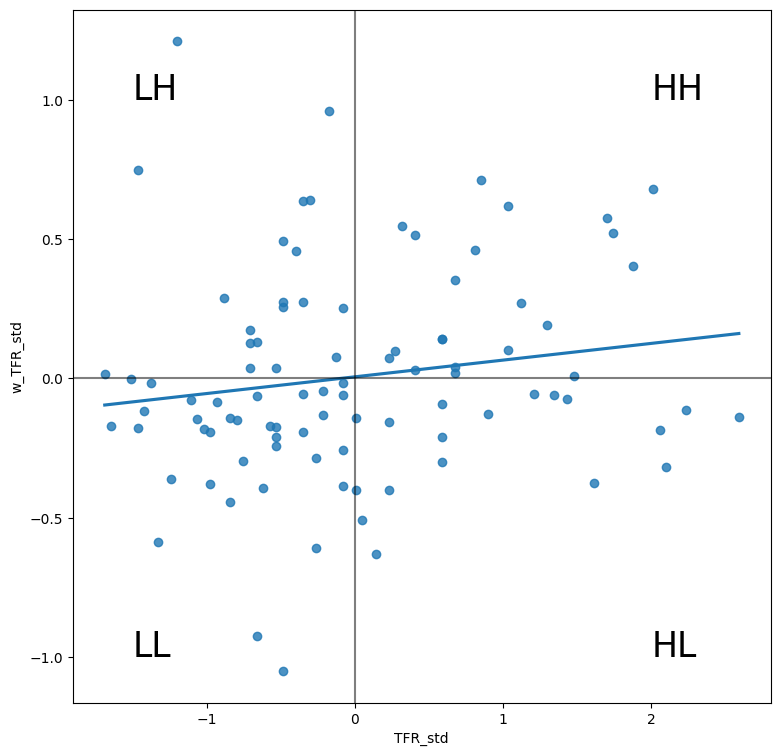

In [406]:
# Lets see where each of the 4 groups (HH, LL, HL, LH) fall into the Moran Plot:
    
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x='TFR_std', y='w_TFR_std', data=gdf, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(2, 1, "HH", fontsize=25)
plt.text(2, -1, "HL", fontsize=25)
plt.text(-1.5, 1, "LH", fontsize=25)
plt.text(-1.5, -1, "LL", fontsize=25)
# Display
plt.show()

### LISA

In [407]:
# calculate LISA for all variables
lisa_TFR = esda.Moran_Local(gdf['TFR'], w)
lisa_master_perc = esda.Moran_Local(gdf['master_perc'], w)
lisa_disp_income_avg_k = esda.Moran_Local(gdf['disp_income_avg_k'], w)
lisa_dwelling_above_74_perc = esda.Moran_Local(gdf['dwelling_above_74_perc'], w)
lisa_household_wealth_avg_k = esda.Moran_Local(gdf['household_wealth_avg_k'], w)

In [408]:
# check if LISA is significant quadrants
for variable in characteristics:
    # Break observations into significant or not
    lisa_value = globals()[f'lisa_{variable}'] 
    gdf[f'{variable}_significant'] = lisa_value.p_sim < 0.05
    # Store the quadrant they belong to
    gdf[f'{variable}_quadrant'] = lisa_value.q

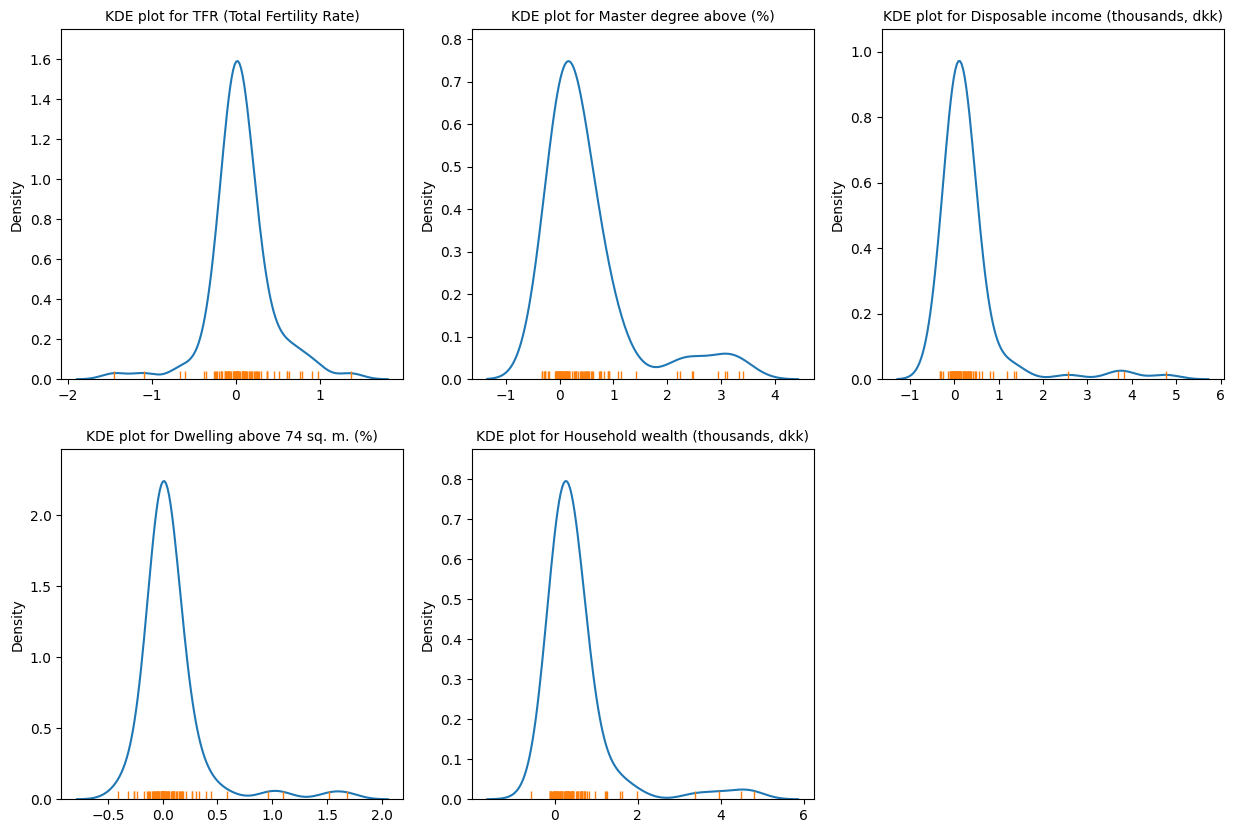

In [409]:
# 
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()

for i, variable in enumerate(characteristics):
    # Draw KDE line
    # Get the corresponding lisa value
    lisa_value = globals()[f'lisa_{variable}'] 
    ax = sns.kdeplot(lisa_value.Is, ax=axs[i])
    # Add one small bar (rug) for each observation
    # along horizontal axis
    sns.rugplot(lisa_value.Is, ax=axs[i])

    # # Remove axis clutter
    # ax.set_axis_off()
    # Set the axis title 
    ax.set_title(f'KDE plot for {characteristics_nm[i]}', fontsize = 10)

plt.show()

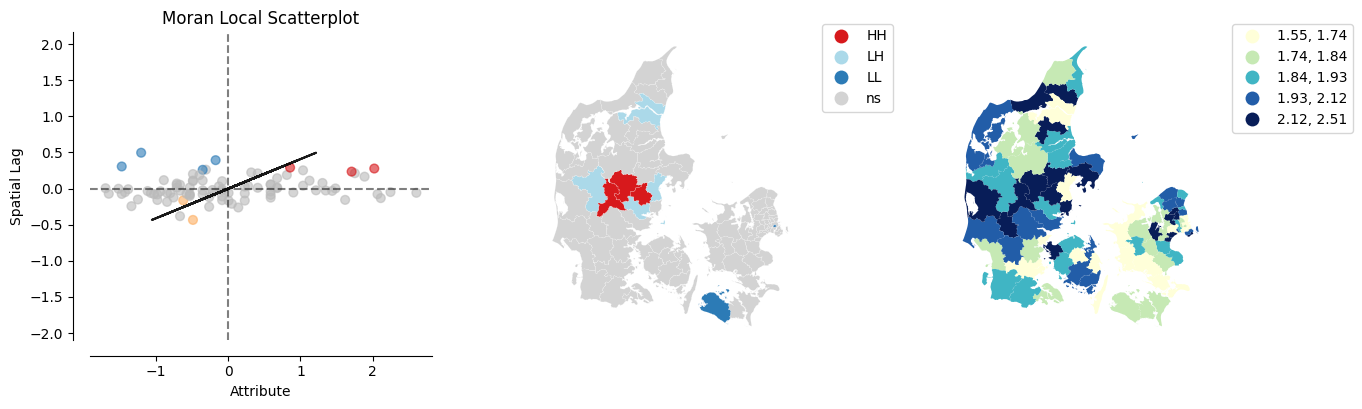

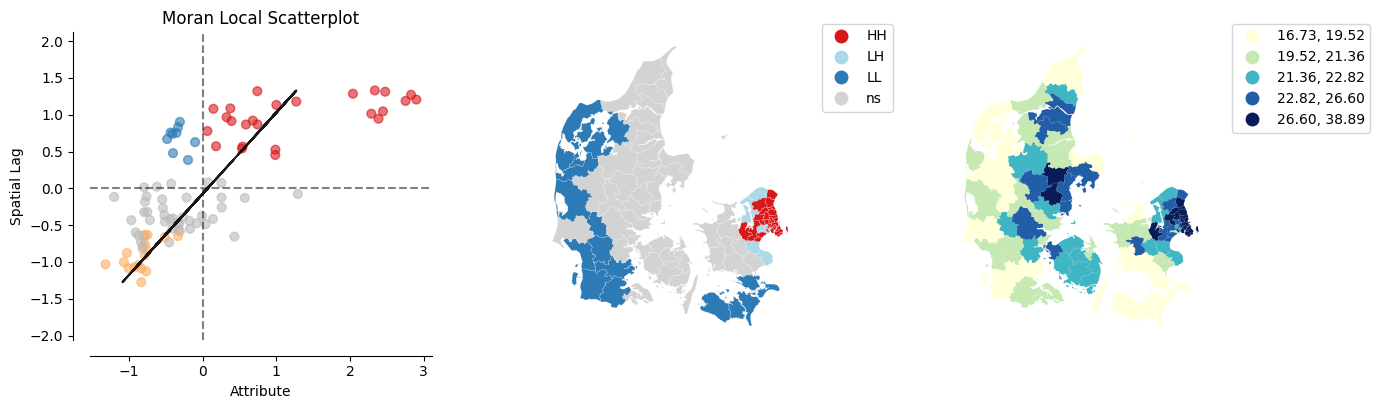

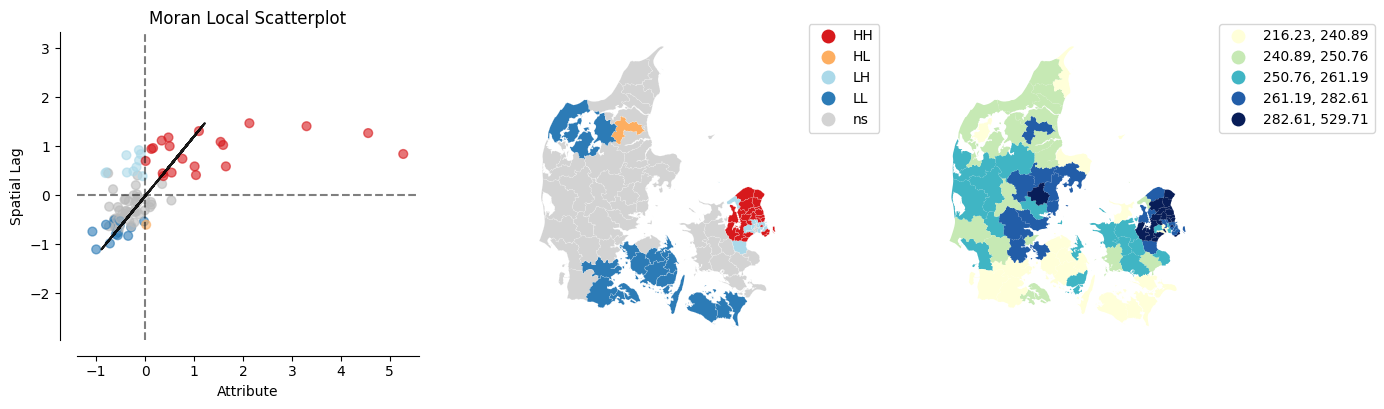

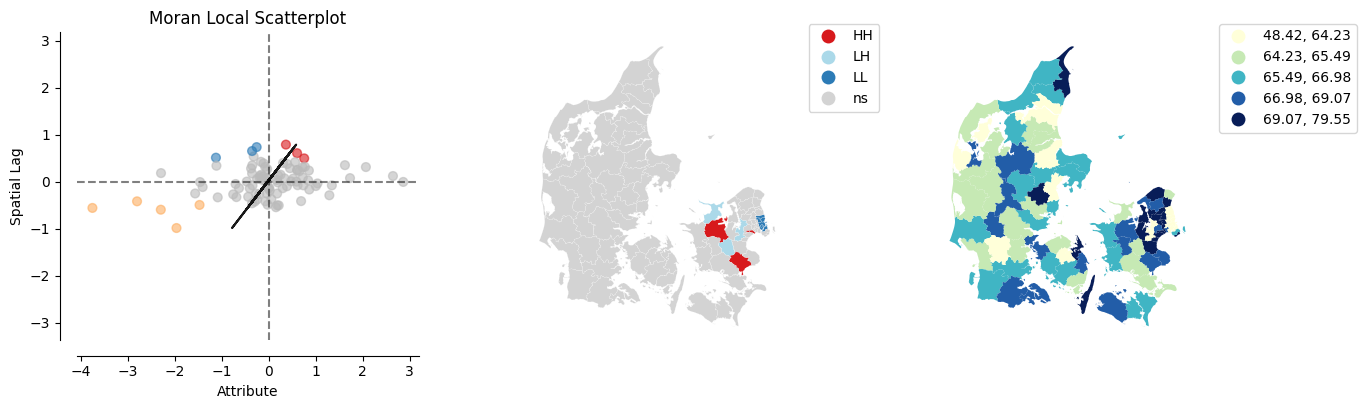

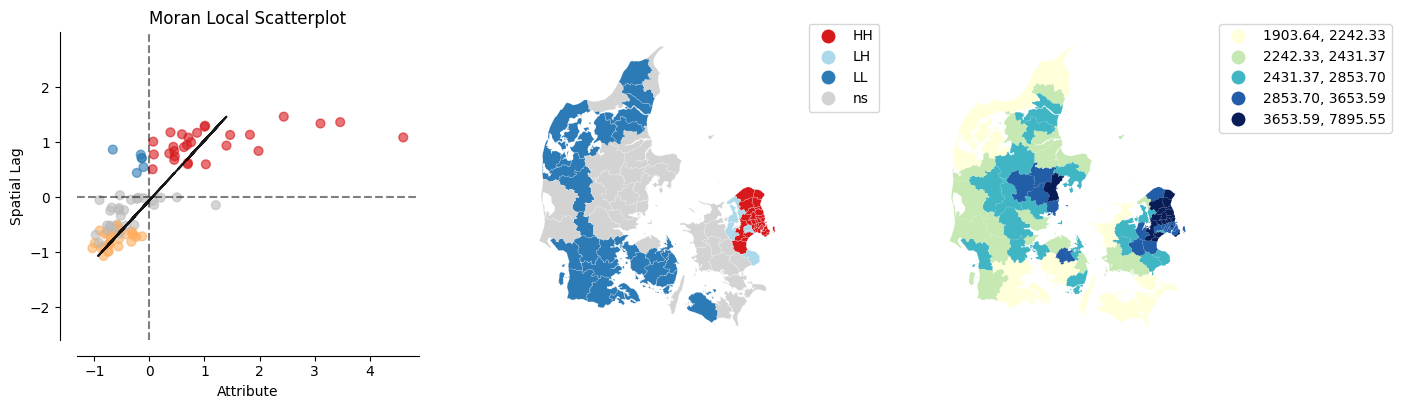

In [410]:
for variable in characteristics:
    lisa_value = globals()[f'lisa_{variable}'] 
    plot_local_autocorrelation(lisa_value, gdf, variable);


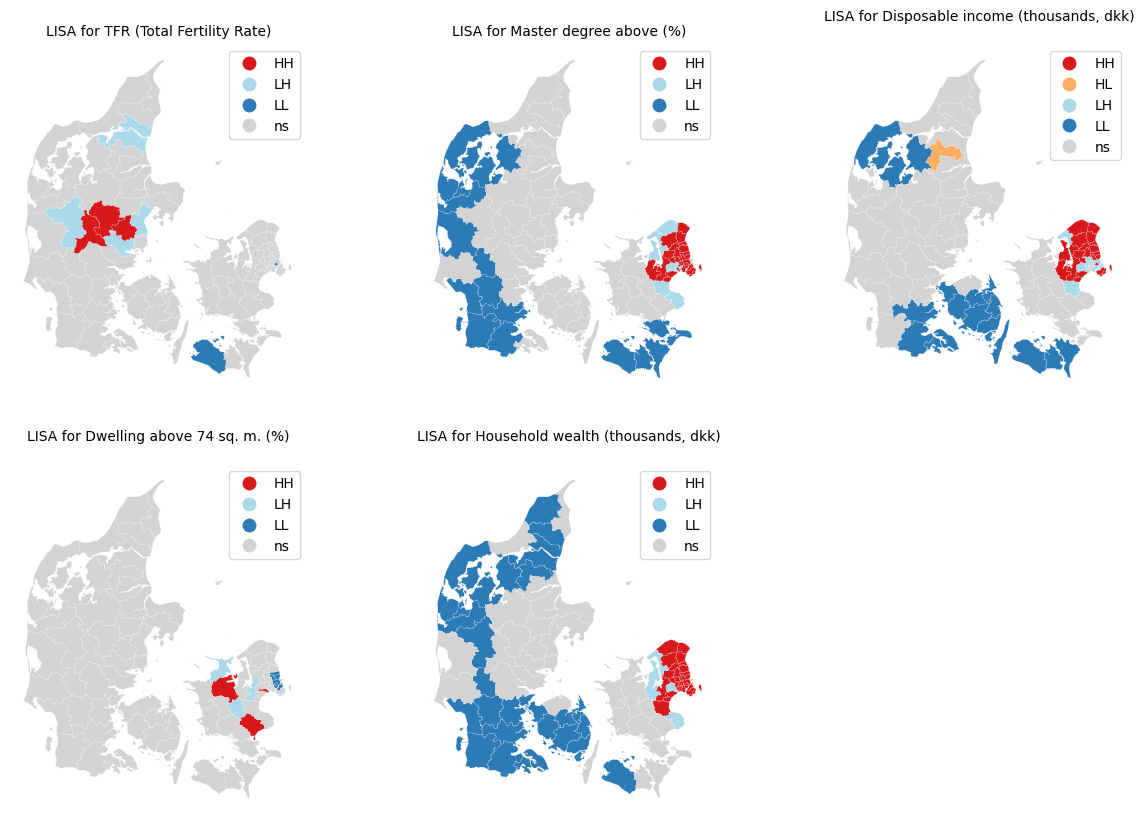

In [411]:
f, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
# Make the axes accessible with single indexing
axs = axs.flatten()
axs[-1].remove()

for i, variable in enumerate(characteristics):
    lisa_value = globals()[f'lisa_{variable}'] 
    fig = lisa_cluster(lisa_value, gdf, ax=axs[i])
    # # Remove axis clutter
    # ax.set_axis_off()
    # Set the axis title 
    axs[i].set_title(f'LISA for {characteristics_nm[i]}', fontsize = 10)

plt.show()


## Clustering

### K-means

Using elbow method to find the optimal k

In [412]:
# TODO: Anna: why this way of scaling?
# scale data
elbow_df = gdf[['TFR', 'master_perc', 'disp_income_avg_k', 'dwelling_above_74_perc', 'household_wealth_avg_k']]
scaled_elbow_df = robust_scale(elbow_df)

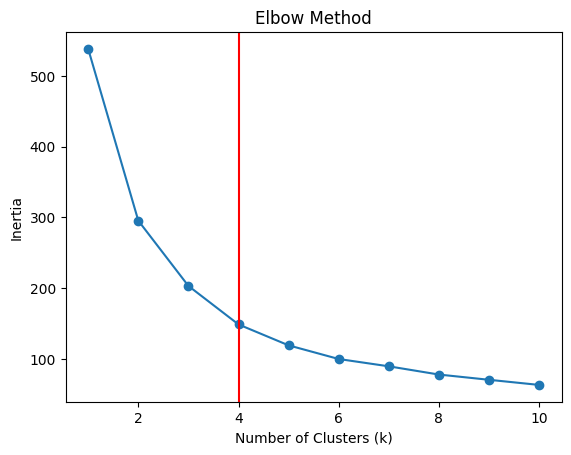

In [413]:
#Define a range of values for k
k_values = range(1, 11)
inertias = []

# Perform k-means clustering for each value of k
for k in k_values:
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(scaled_elbow_df)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
#plt.savefig('ElbowMethod.png')
# Add a red line at x=4
plt.axvline(x=4, color='red')
plt.show()

In [414]:
# Perform K-means clustering with 4 clusters
kmeans4 = cluster.KMeans(n_clusters=4, random_state=12345)

In [415]:
# scale data with robust scale, so that it is robust to outliers. 
for c in characteristics:
    gdf[c+'_scaled'] = robust_scale(gdf[c])
    
cluster_cols_scaled = [c+'_scaled' for c in characteristics]

In [416]:
# Run the clustering algorithm on scaled data
knn4cls = kmeans4.fit(gdf[cluster_cols_scaled])

In [417]:
knn4cls.labels_

array([2, 2, 0, 1, 1, 1, 1, 3, 2, 2, 2, 2, 1, 1, 3, 2, 0, 0, 0, 0, 1, 0,
       1, 1, 2, 0, 3, 3, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2])

In [418]:
# Append knn column to original data
gdf['knn4'] = knn4cls.labels_

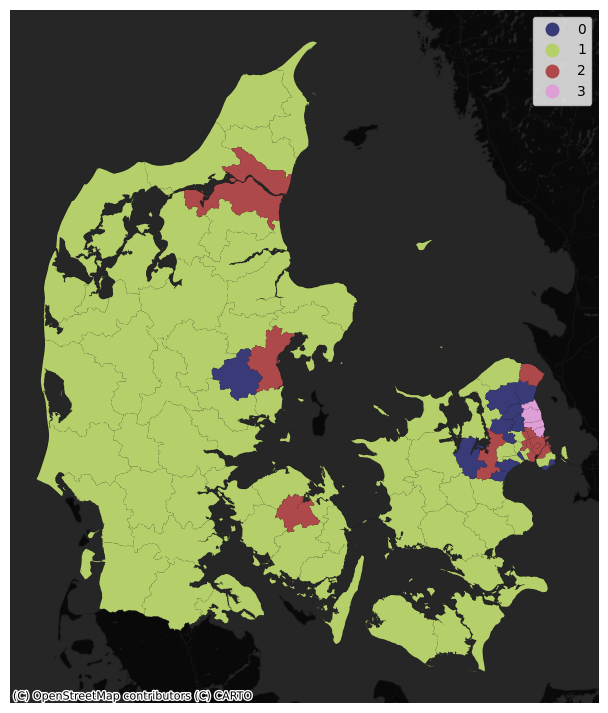

In [419]:
# Plot clusters 
f, ax = plt.subplots(1, figsize=(9, 9))

gdf.plot(
    column='knn4', 
    categorical=True, 
    legend=True, 
    linewidth=0, 
    ax=ax, 
    cmap='tab20b'
)
# Remove axis
ax.set_axis_off()

# Add basemap
cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels 
)
#plt.savefig('Kmeanscluster.png')
# Display the map
plt.show()

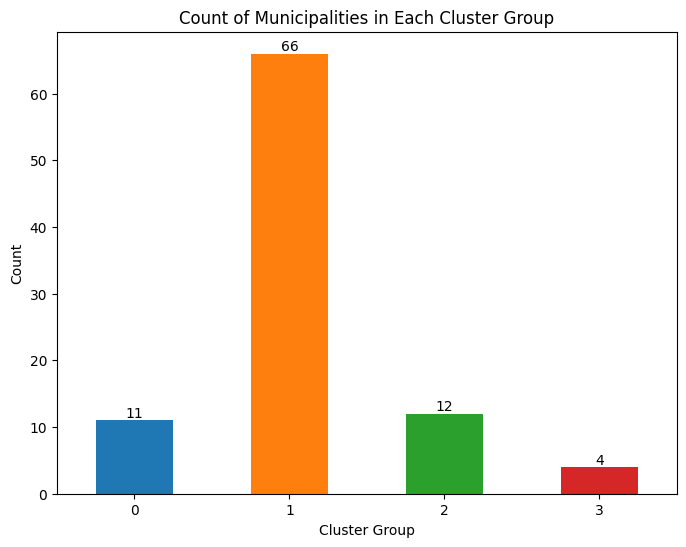

In [420]:
# Plot the municiplality count for each cluster 
knn4sizes = gdf.groupby('knn4').size()

ax = knn4sizes.plot(kind='bar', figsize=(8, 6), color=sns.color_palette())
ax.set_title('Count of Municipalities in Each Cluster Group')
ax.set_xlabel('Cluster Group')
ax.set_ylabel('Count')

# Add count labels on top of each bar
for i, count in enumerate(knn4sizes):
    ax.text(i, count, str(count), ha='center', va='bottom')
    
# Rotate x-axis labels
plt.xticks(rotation=360)

plt.show()

In [421]:
# table that shows each municipality along with their fertility rate and cluster group
cluster_fertility = gdf[['municipality_nm', 'TFR', 'knn4']]
cluster_fertility.sort_values(by='knn4')

,municipality_nm,TFR,knn4
municipal_id,,,
190,Furesø,2.23,0
210,Fredensborg,2.02,0
240,Egedal,2.25,0
201,Allerød,2.26,0
187,Vallensbæk,2.06,0
...,...,...,...
851,Aalborg,1.60,2
230,Rudersdal,2.06,3
223,Hørsholm,1.90,3


In [422]:
# Calculate the mean by cluster group
k4means = gdf.groupby('knn4')[characteristics].mean()

k4means.T

knn4,0,1,2,3
TFR,2.240000,1.917727,1.735000,1.8350
master_perc,29.943636,21.098485,27.546667,36.9250
disp_income_avg_k,313.378182,250.375455,270.630000,457.6975
dwelling_above_74_perc,73.177273,66.634848,59.329167,57.7625
household_wealth_avg_k,3990.347273,2502.310000,3652.367500,6617.1150


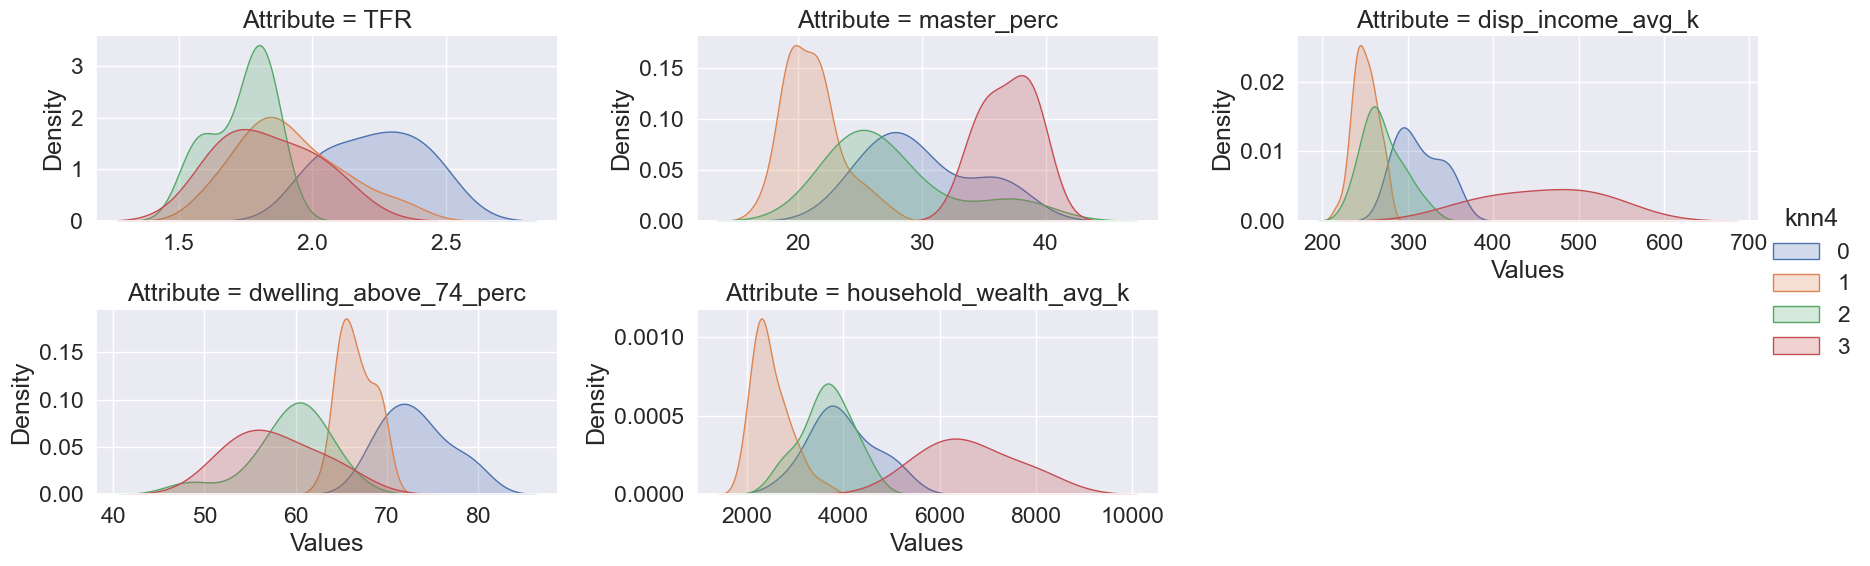

In [428]:
# Draw the distributions of cluster members’ data:

# Index on cluster ID
tidy_db = gdf.set_index('knn4')
# Keep only variables used for clustering
tidy_db = tidy_db[characteristics]
# Stack column names into a column
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)



# Scale fonts 
sns.set(font_scale=1.5)
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='knn4',
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)

facets.map(sns.kdeplot, "Values", fill=True,warn_singular=False).add_legend();

### Regionalization 

In [429]:
# spatially-constrained version of the agglomerative algorithm

sagg13 = cluster.AgglomerativeClustering(n_clusters=8, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<93x93 sparse matrix of type '<class 'numpy.float64'>'
	with 1622 stored elements in Compressed Sparse Row format>,
                        n_clusters=8)

In [430]:
# Run the clustering algorithm with scaled data
# TODO: how to scale data and why
sagg13cls = sagg13.fit(gdf[cluster_cols_scaled])

In [431]:
# add to dataframe
gdf['sagg13cls'] = sagg13cls.labels_

In [433]:
# Calculate the mean by group
sagg13_data = gdf.groupby('sagg13cls')[characteristics].mean()

sagg13_data.T

sagg13cls,0,1,2,3,4,5,6,7
TFR,1.794872,1.676667,2.213333,1.886667,1.855556,2.304,2.333333,2.0072
master_perc,21.221538,36.906667,27.533333,37.256667,26.416667,26.232,36.126667,20.3008
disp_income_avg_k,248.035385,319.006667,302.116667,485.413333,276.664444,277.122,348.143333,249.2372
dwelling_above_74_perc,66.741795,52.716667,74.775000,59.386667,62.832222,67.074,72.923333,65.5332
household_wealth_avg_k,2598.282051,4569.993333,3658.138333,6958.696667,3669.900000,3135.238,4868.260000,2326.6072


In [434]:
# custom colormap to ensure uniform colors between plots and maps
colors = ["#a6cee3",
"#1f78b4",
#"#b2df8a",
"#33a02c",
"#fb9a99",
"#e31a1c",
"#fdbf6f",
#"#ff7f00",
#"#cab2d6",
"#6a3d9a",
#"#ffff99",
"#b15928"]

keys = list(range(0,12))

color_dict={}

for k, c in zip(keys, colors):
    color_dict[k] = c

vals = gdf.sagg13cls.unique()
vals.sort()
cmap = mpl.colors.ListedColormap([color_dict[b] for b in vals])

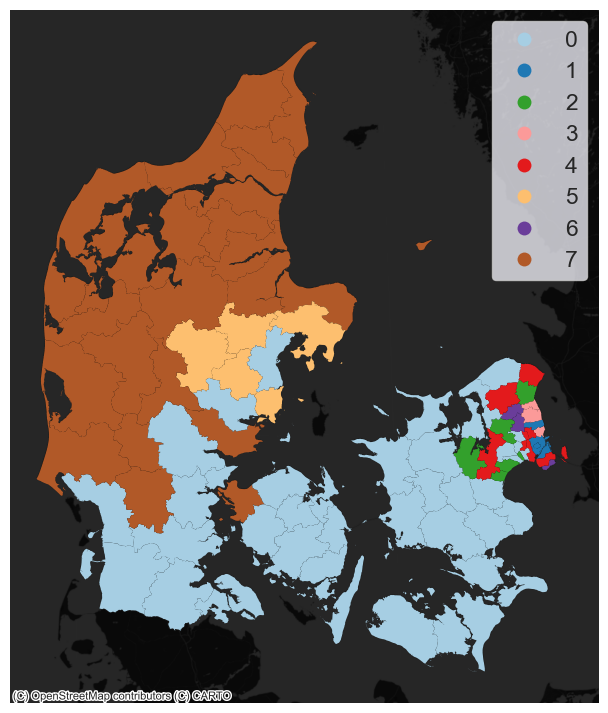

In [435]:
# Plot clusters 
f, ax = plt.subplots(1, figsize=(9,9))

gdf.plot(
    column='sagg13cls', categorical=True, legend=True, linewidth=0, cmap=cmap, ax=ax
)
# Remove axis
ax.set_axis_off()

# Add basemap
cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels 
)
plt.savefig('KmeansclusterReg.png')

# Display the map
plt.show()

Draw the distributions of cluster members’ data:

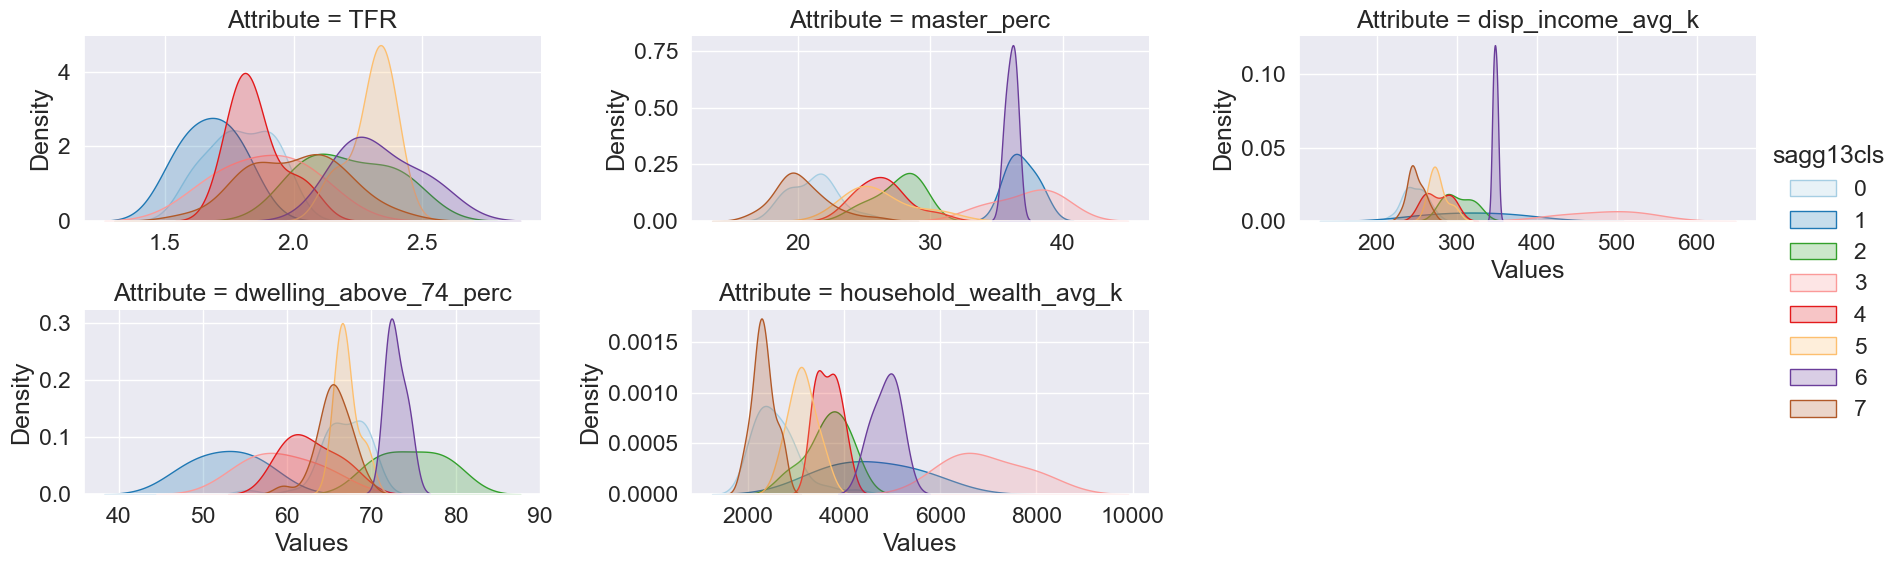

In [437]:
# Index on cluster ID
tidy_db = gdf.set_index('sagg13cls')
# Keep only variables used for clustering
tidy_db = tidy_db[characteristics]
# Stack column names into a column
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)

#sns.set(font_scale=1.5)

facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='sagg13cls',
    sharey=False,
    sharex=False,
    aspect=2,
    palette= colors, #'tab20',
    col_wrap=3,
)

facets.map(sns.kdeplot, "Values", fill=True, warn_singular=False).add_legend();

In [ ]:
# TODO: comparison: two plots in one 